In [1]:
import dgl
from matplotlib import pyplot as plt
from matplotlib.ticker import FuncFormatter
import networkx as nx
import numpy as np
import os
import pandas as pd
import random
import seaborn as sns
from time import time
import torch
import warnings
import yfinance as yf

from utils import build_nx_graph, gen_q_dict_mis, gen_q_dict_mis_handcrafted, qubo_dict_to_torch, \
    get_gnn, run_gnn_training, loss_func, postprocess_gnn_mis, run_mis_solver
from utils_backtest import portfolio_return, sharpe_ratio, sortino_ratio, \
    max_drawdown, calmar_ratio
from utils_backtest import max_drawdown_series, annualized_sharpe_ratio, annualized_sortino_ratio, \
    annualized_max_drawdown, annualized_calmar_ratio
from utils_distance_correlation import df_distance_correlation

warnings.filterwarnings('ignore', category=UserWarning, message='TypedStorage is deprecated')

In [2]:
# fix seed to ensure consistent results
seed_value = 1
random.seed(seed_value)        # seed python RNG
np.random.seed(seed_value)     # seed global NumPy RNG
torch.manual_seed(seed_value)  # seed torch RNG

# Set GPU/CPU
TORCH_DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
TORCH_DTYPE = torch.float32
print(f'Will use device: {TORCH_DEVICE}, torch dtype: {TORCH_DTYPE}')

Will use device: cpu, torch dtype: torch.float32


In [3]:
RISK_FREE_RATE = 0.01
THRESHOLD = 0.35

## Data pre-processing

The asset universe is limited to stocks in the **Standard and Poor’s 500**. The S&P500 is a stock market index tracking the returns of the largest 500 companies listed on US stock exchanges. The index includes about 80% of the American equity market by capitalization and is one of the best-known stock indices. It includes some of the largest corporation in the world, such as Apple, Microsoft, Amazon, Johnson & Johnson, ExxonMobil and many others. A full list of stocks, which are included in the S&P500 can be found on [Wikipedia](https://en.wikipedia.org/wiki/List_of_S%26P_500_companies).

In [4]:
sp500_hist = pd.read_csv(
    "./data/sp500_hist_prices.csv",
    parse_dates=['Date'],
    index_col='Date')

sp500_hist = sp500_hist.loc['2014-01-01':,]
sp500_hist.dropna(axis=1, inplace=True)

print(f'Shape: {sp500_hist.shape}')
sp500_hist.head()

Shape: (2266, 470)


A        AAL         AAP       AAPL       ABBV        ABC   
Date                                                                            
2014-01-02  37.141602  23.907921  101.185295  17.388981  35.240082  60.504734  \
2014-01-03  37.610752  25.020359  104.080498  17.007023  35.457024  60.548027   
2014-01-06  37.425739  25.482304  103.084709  17.099760  34.162140  60.331593   
2014-01-07  37.960957  25.369169  104.357124  16.977465  34.229923  60.989532   
2014-01-08  38.582062  26.047947  103.545738  17.084980  34.141792  61.586887   

                  ABT       ACGL        ACN       ADBE  ...        WYNN   
Date                                                    ...               
2014-01-02  31.847378  19.123333  68.658348  59.290001  ...  169.137527  \
2014-01-03  32.188923  18.756666  68.886833  59.160000  ...  167.479828   
2014-01-06  32.613773  18.580000  68.159042  58.119999  ...  167.360214   
2014-01-07  32.363853  18.586666  68.988396  58.970001  ...  172.188049   
2014-01-08  32.655426  18.476667  69.521561  58.900002  ...  175.417999   

                  XEL        XOM       XRAY        XYL        YUM        ZBH   
Date                                                                           
2014-01-02  20.609207  66.582367  44.643036  30.301586  45.261662  83.170258  \
2014-01-03  20.601709  66.422142  44.857124  30.576576  45.544949  83.530914   
2014-01-06  20.489336  66.522278  44.587177  30.523350  45.508789  84.071892   
2014-01-07  20.841444  67.463448  45.276005  30.612062  46.147724  85.749016   
2014-01-08  20.759035  67.243179  45.359783  30.594316  46.129646  87.849907   

                 ZBRA       ZION        ZTS  
Date                                         
2014-01-02  53.180000  24.822664  30.329689  
2014-01-03  53.580002  24.998468  30.039131  
2014-01-06  53.400002  24.822664  29.973518  
2014-01-07  53.950001  24.898008  30.085989  
2014-01-08  53.910000  25.115677  29.748577  

[5 rows x 470 columns]

We use the S&P500 Index as a benchmark to compare our portfolio performances.

In [5]:
gspc = yf.download(
    tickers="^GSPC", 
    start=sp500_hist.index[0].strftime(format="%Y-%m-%d"), 
    end=sp500_hist.index[-1].strftime(format="%Y-%m-%d")
)['Adj Close']

gspc

[*********************100%***********************]  1 of 1 completed


Date
2014-01-02    1831.979980
2014-01-03    1831.369995
2014-01-06    1826.770020
2014-01-07    1837.880005
2014-01-08    1837.489990
                 ...     
2022-12-22    3822.389893
2022-12-23    3844.820068
2022-12-27    3829.250000
2022-12-28    3783.219971
2022-12-29    3849.280029
Name: Adj Close, Length: 2265, dtype: float64

### Train/Test Split

We use five years (2014-2019) as the trainigs period. Meaning the correlation measures are calculated on this period. Two years (2020-2021) are used as testing period. As we can during this time the market direction was identical to the mark

In [6]:
TRAIN_START_DATE, TRAIN_END_DATE = "2014-01-01", "2019-01-01"
VAL_START_DATE, VAL_END_DATE = TRAIN_END_DATE, "2021-01-01"
TEST_START_DATE, TEST_END_DATE = VAL_END_DATE, "2022-12-30"

df_train = sp500_hist.loc[TRAIN_START_DATE:TRAIN_END_DATE,:]
df_val = sp500_hist.loc[VAL_START_DATE:VAL_END_DATE,:]
df_test = sp500_hist.loc[TEST_START_DATE:TEST_END_DATE,:]

gspc_train = gspc.loc[TRAIN_START_DATE:TRAIN_END_DATE]
gspc_val = gspc.loc[VAL_START_DATE:VAL_END_DATE]
gspc_test = gspc.loc[TEST_START_DATE:TEST_END_DATE]

print(f"Train shape: {df_train.shape}")
print(f"Validation shape: {df_val.shape}")
print(f"Test shape: {df_test.shape}")

assert df_train.shape[1] == df_val.shape[1] and df_val.shape[1] == df_test.shape[1]
assert df_train.shape[0] == gspc_train.shape[0] 
assert df_val.shape[0] == gspc_val.shape[0]
assert df_test.shape[0] == gspc_test.shape[0] + 1


Train shape: (1258, 470)
Validation shape: (505, 470)
Test shape: (503, 470)


### Build correlation matrix

In [7]:
df_train_pct = df_train.pct_change()
df_train_pct = df_train_pct.iloc[1:]
assert df_train_pct.isnull().any

#### Pearson Correlation Coefficient

Pearson's Correlation Coefficient is a widely used **linear** correlation measure. Mathematically speaking, it is defined as “the covariance between two vectors, normalized by the product of their standard deviations.

In [8]:
df_corr_pearson = df_train_pct.corr(method='pearson').abs()

print(f"Median Correlation Value: {df_corr_pearson.quantile(0.5).mean():.4f}")
df_corr_pearson.head()

Median Correlation Value: 0.2980


A       AAL       AAP      AAPL      ABBV       ABC       ABT   
A     1.000000  0.382742  0.219645  0.414948  0.421869  0.304739  0.574249  \
AAL   0.382742  1.000000  0.225041  0.266363  0.248515  0.261891  0.354514   
AAP   0.219645  0.225041  1.000000  0.164521  0.207446  0.187494  0.272270   
AAPL  0.414948  0.266363  0.164521  1.000000  0.249677  0.210316  0.404470   
ABBV  0.421869  0.248515  0.207446  0.249677  1.000000  0.360658  0.466849   

          ACGL       ACN      ADBE  ...      WYNN       XEL       XOM   
A     0.331965  0.549816  0.514034  ...  0.322726  0.129615  0.393839  \
AAL   0.300311  0.342551  0.341944  ...  0.229990  0.050026  0.180990   
AAP   0.166838  0.248961  0.201158  ...  0.110759  0.138697  0.213190   
AAPL  0.252869  0.434179  0.445038  ...  0.240328  0.103077  0.322874   
ABBV  0.192885  0.342592  0.332743  ...  0.225820  0.134010  0.305388   

          XRAY       XYL       YUM       ZBH      ZBRA      ZION       ZTS  
A     0.379775  0.527850  0.403163  0.461232  0.398479  0.446531  0.459521  
AAL   0.276014  0.340913  0.279464  0.287089  0.279151  0.358160  0.299588  
AAP   0.185469  0.251198  0.242426  0.224925  0.216907  0.287356  0.201817  
AAPL  0.275392  0.336190  0.329327  0.348979  0.337855  0.311279  0.346728  
ABBV  0.330411  0.339783  0.254616  0.401070  0.245127  0.300406  0.411759  

[5 rows x 470 columns]

#### Distance Correlation Coefficient

Distance Correlation Coefficient is defined as the “distance covariance” normalized by the “dis-tance standard deviation”. Instead of assessing how two variables tend to co-vary in their distance from their respective means, distance correlation assesses how they tend to co-vary in terms of their distances from all other points. This opens the potential to better capture **non-linear** depend-encies between variables. 

In [9]:
dcor_path = './data/correlation_matrix_dcor.csv'

if not os.path.exists(dcor_path):
    df_corr_dcor = df_distance_correlation(
    df_train=df_train_pct, 
    stocks=df_train_pct.columns.to_list())
    df_corr_dcor.to_csv(dcor_path)

df_corr_dcor = pd.read_csv(dcor_path, index_col=0)

print(f"Median Correlation Value: {df_corr_dcor.quantile(0.5).mean():.4f}")
df_corr_dcor.head()

Median Correlation Value: 0.3167


A       AAL       AAP      AAPL      ABBV       ABC       ABT   
A     1.000000  0.370769  0.280320  0.406274  0.441936  0.340056  0.550617  \
AAL   0.370769  1.000000  0.252693  0.268759  0.241136  0.282556  0.322013   
AAP   0.280320  0.252693  1.000000  0.214710  0.242787  0.258569  0.302253   
AAPL  0.406274  0.268759  0.214710  1.000000  0.272596  0.240476  0.389665   
ABBV  0.441936  0.241136  0.242787  0.272596  1.000000  0.377955  0.498962   

          ACGL       ACN      ADBE  ...      WYNN       XEL       XOM   
A     0.315125  0.554897  0.510059  ...  0.338717  0.133907  0.384667  \
AAL   0.272014  0.317689  0.327121  ...  0.238032  0.059439  0.161157   
AAP   0.239381  0.293609  0.262833  ...  0.152884  0.128376  0.221394   
AAPL  0.240751  0.422469  0.445344  ...  0.279031  0.113409  0.302957   
ABBV  0.226880  0.371773  0.352876  ...  0.259885  0.165061  0.287647   

          XRAY       XYL       YUM       ZBH      ZBRA      ZION       ZTS  
A     0.451648  0.518916  0.420439  0.503341  0.459211  0.419441  0.478870  
AAL   0.291753  0.314876  0.306836  0.306738  0.331425  0.323060  0.295755  
AAP   0.269603  0.272197  0.297626  0.267731  0.250553  0.321172  0.242498  
AAPL  0.309033  0.330494  0.341278  0.348092  0.364536  0.288075  0.346662  
ABBV  0.370497  0.334443  0.299893  0.442624  0.322106  0.271527  0.457464  

[5 rows x 470 columns]

#### Quantile Correlation Coefficient

Quantile Correlation Coefficient is newly defined as the geometric mean of two quantile regres-sion slopes—that of X on Y and that of Y on X—in the same way that the Pearson correlation coeffi-cient is related to regression coefficients. The quantile correlation is a measure of overall sensitivity of a conditional quantile of a random variable to changes in the other variable.

There are no heuristics how to choose the best quantile value. Hence, I decided to test two different quantile values (0.1 and 0.2).

In [10]:
df_corr_quantile_01 = pd.read_csv('./data/correlation_matrix_q01.csv', index_col=0).abs()
print(f"Quantile Correlation Value (q=.1): {df_corr_quantile_01.quantile(0.5).mean():.4f}")
df_corr_quantile_01.head()

df_corr_quantile_02 = pd.read_csv('./data/correlation_matrix_q02.csv', index_col=0).abs()
print(f"Quantile Correlation Value (q=.2): {df_corr_quantile_02.quantile(0.5).mean():.4f}")
df_corr_quantile_02.head()

Quantile Correlation Value (q=.1): 0.3351
Quantile Correlation Value (q=.2): 0.3240


A       AAL       AAP      AAPL      ABBV       ABC       ABT   
A     1.000000  0.403794  0.275985  0.469337  0.479691  0.357417  0.612188  \
AAL   0.403794  1.000000  0.240718  0.288785  0.267426  0.267209  0.345385   
AAP   0.275985  0.240718  1.000000  0.198237  0.193474  0.232512  0.284062   
AAPL  0.469337  0.288785  0.198237  1.000000  0.244767  0.230215  0.413776   
ABBV  0.479691  0.267426  0.193474  0.244767  1.000000  0.383824  0.494710   

          ACGL       ACN      ADBE  ...      WYNN       XEL       XOM   
A     0.332851  0.600031  0.543742  ...  0.343103  0.161786  0.443891  \
AAL   0.288580  0.357499  0.351005  ...  0.229045  0.025005  0.184492   
AAP   0.192692  0.253126  0.221621  ...  0.120094  0.141732  0.220864   
AAPL  0.237200  0.467539  0.470785  ...  0.245100  0.117440  0.354930   
ABBV  0.218449  0.408085  0.372882  ...  0.263022  0.162137  0.319852   

          XRAY       XYL       YUM       ZBH      ZBRA      ZION       ZTS  
A     0.493360  0.528485  0.464409  0.531264  0.468679  0.487343  0.505420  
AAL   0.328612  0.334798  0.315232  0.324696  0.313551  0.384990  0.309724  
AAP   0.224057  0.253295  0.251340  0.222464  0.212006  0.269855  0.201842  
AAPL  0.336368  0.370746  0.311080  0.383709  0.354914  0.346775  0.365311  
ABBV  0.386581  0.353470  0.291044  0.453231  0.291014  0.309548  0.459816  

[5 rows x 470 columns]

In [11]:
STOCK_NAMES = df_corr_pearson.columns.values

## Building the Graphs

The correlation matrices are used to build graphs. For each correlation matrix a graph gets created. The correlation coefficients get binarized. For values greater or equal the threshold an edge will be created.

In [12]:
# pearson correlation graph
print("Building 'Pearson Correlation' graph...")
nx_graph_pearson = build_nx_graph(
    df_corr=df_corr_pearson,
    threshold=THRESHOLD
)
assert (df_corr_pearson.where(df_corr_pearson >= THRESHOLD).count().sum() - len(df_corr_pearson)) / 2 == len(nx_graph_pearson.edges)

# distance correlation graph
print("Building 'Distance Correlation' graph...")
nx_graph_dcor = build_nx_graph(
    df_corr=df_corr_dcor,
    threshold=THRESHOLD
)
assert (df_corr_dcor.where(df_corr_dcor >= THRESHOLD).count().sum() - len(df_corr_dcor)) / 2 == len(nx_graph_dcor.edges)

# quantile correlation graph (q=.1)
print("Building 'Quantile Correlation' (q=.1) graph...")
nx_graph_quantile_01 = build_nx_graph(
    df_corr=df_corr_quantile_01,
    threshold=THRESHOLD
)
assert (df_corr_quantile_01.where(df_corr_quantile_01 >= THRESHOLD).count().sum() - len(df_corr_quantile_01)) / 2 == len(nx_graph_quantile_01.edges)

# quantile correlation graph (q=.2)
print("Building 'Quantile Correlation' (q=.2) graph...")
nx_graph_quantile_02 = build_nx_graph(
    df_corr=df_corr_quantile_02,
    threshold=THRESHOLD
)
assert (df_corr_quantile_02.where(df_corr_quantile_02 >= THRESHOLD).count().sum() - len(df_corr_quantile_02)) / 2 == len(nx_graph_quantile_02.edges)

Building 'Pearson Correlation' graph...
Building 'Distance Correlation' graph...
Building 'Quantile Correlation' (q=.1) graph...
Building 'Quantile Correlation' (q=.2) graph...


In [13]:
print(f"#Edges Pearson Correlation Graph: {len(nx_graph_pearson.edges)}")
print(f"#Edges Distnace Correlation Graph: {len(nx_graph_dcor.edges)}")
print(f"#Edges Quantile Correlation Graph (q=.1): {len(nx_graph_quantile_01.edges)}")
print(f"#Edges Quantile Correlation Graph (q=.2): {len(nx_graph_quantile_02.edges)}")

#Edges Pearson Correlation Graph: 34704
#Edges Distnace Correlation Graph: 40433
#Edges Quantile Correlation Graph (q=.1): 48542
#Edges Quantile Correlation Graph (q=.2): 44343


### Plot degree distribution

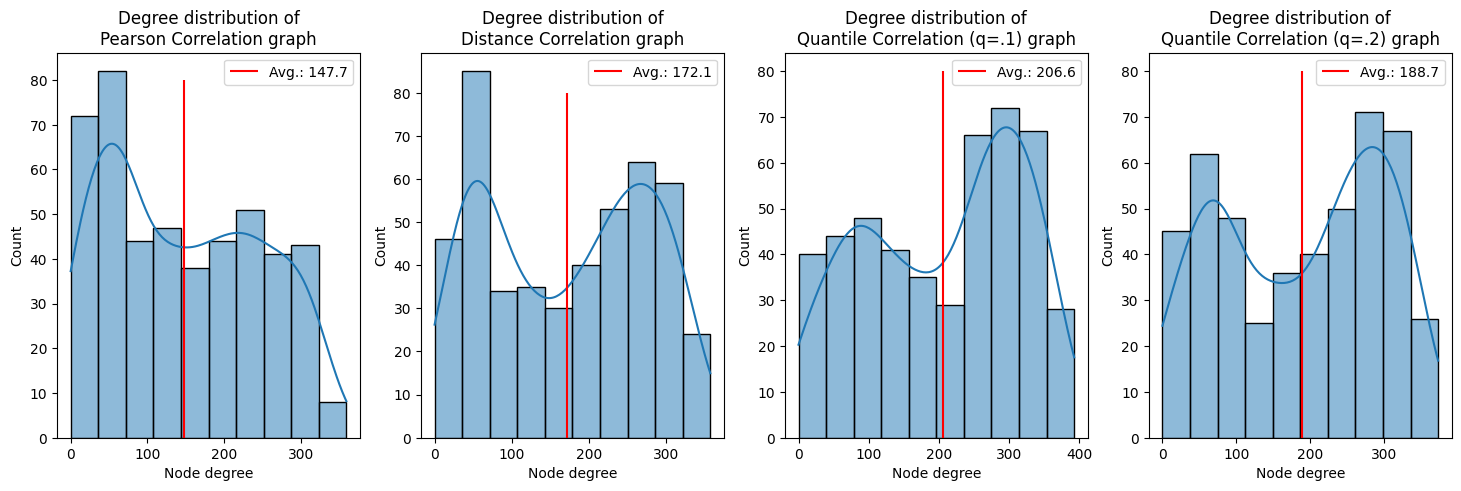

In [14]:
def plot_degree_distr(graph:nx.Graph, ax:plt.Axes, title:str) -> None:
    """ Plots the degree distribution of a graph."""
    degrees = [degree for (_, degree) in graph.degree()]
    avg_degree = sum(degrees) / len(degrees)

    sns.histplot(degrees, kde=True, ax=ax)
    ax.vlines(avg_degree, ymin=0, ymax=80, colors=['r'], label=f"Avg.: {avg_degree:.1f}")
    ax.set_title(title)
    ax.set_xlabel("Node degree")
    ax.legend()

_, (ax0, ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=4, figsize=(18, 5))

# Pearson correlation graph
plot_degree_distr(
    graph=nx_graph_pearson, 
    ax=ax0, 
    title="Degree distribution of\nPearson Correlation graph")

# Distance correlation graph
plot_degree_distr(
    graph=nx_graph_dcor, 
    ax=ax1, 
    title="Degree distribution of\nDistance Correlation graph")

# Quantile correlation (q=.1) graph
plot_degree_distr(
    graph=nx_graph_quantile_01, 
    ax=ax2, 
    title="Degree distribution of\nQuantile Correlation (q=.1) graph")

# Quantile correlation (q=.2) graph
plot_degree_distr(
    graph=nx_graph_quantile_02, 
    ax=ax3, 
    title="Degree distribution of\nQuantile Correlation (q=.2) graph")

plt.show()

### Building the *Q* matrix

The quadratic unconstraint binary optimization (QUBO) Framework unifies various NP-hard combi-natorial optimization problems. The cost function for a QUBO problem can be expressed in compact form:

$ H_{QUBO}=X^{T}Qx=\sum_{i,j}x_{i}Q_{i,j}x_{j} $

The QUBO matrix *Q* is a square matrix that encodes the actual problem. For undirected graphs the *Q* matrix can be assumed to be symmetric or in the upper diagonal form.

In [15]:
# Pearson graph
graph_dgl_pearson = dgl.from_networkx(nx_graph=nx_graph_pearson)
graph_dgl_pearson = graph_dgl_pearson.to(TORCH_DEVICE)

q_torch_pearson = qubo_dict_to_torch(
    nx_G=nx_graph_pearson, 
    Q=gen_q_dict_mis(nx_G=nx_graph_pearson, penalty=2), 
    torch_dtype=TORCH_DTYPE, 
    torch_device=TORCH_DEVICE)

# Distance correlation graph
graph_dgl_dcor = dgl.from_networkx(nx_graph=nx_graph_dcor)
graph_dgl_dcor = graph_dgl_dcor.to(TORCH_DEVICE)

q_torch_dcor = qubo_dict_to_torch(
    nx_G=nx_graph_dcor, 
    Q=gen_q_dict_mis(nx_G=nx_graph_dcor, penalty=3), 
    torch_dtype=TORCH_DTYPE, 
    torch_device=TORCH_DEVICE)

# Quantile graph (q=.1)
graph_dgl_quantile_01 = dgl.from_networkx(nx_graph=nx_graph_quantile_01)
graph_dgl_quantile_01 = graph_dgl_quantile_01.to(TORCH_DEVICE)

q_torch_quantile_01 = qubo_dict_to_torch(
    nx_G=nx_graph_quantile_01, 
    Q=gen_q_dict_mis(nx_G=nx_graph_quantile_01, penalty=2), 
    torch_dtype=TORCH_DTYPE, 
    torch_device=TORCH_DEVICE)

# Quantile graph (q=.2)
graph_dgl_quantile_02 = dgl.from_networkx(nx_graph=nx_graph_quantile_02)
graph_dgl_quantile_02 = graph_dgl_quantile_02.to(TORCH_DEVICE)

q_torch_quantile_02 = qubo_dict_to_torch(
    nx_G=nx_graph_quantile_02, 
    Q=gen_q_dict_mis(nx_G=nx_graph_quantile_02, penalty=2), 
    torch_dtype=TORCH_DTYPE, 
    torch_device=TORCH_DEVICE)

### Handcrafted *Q* Matrix (Optional)

Above I use the proposed *Q* Matrix from Schuetz et. al. To optimize a portfolio it might be more beneficial to use a *Q* Matrix which uses higher rewards for well performing stocks and vice versa. Here I use the Sortino Ratio as reward, this allows to encode estimated returns and stocks volatility.

In [16]:
# handcrafted correlation graph
print("Building 'Handcrafted Correlation' graph...")
nx_graph_handcrafted = build_nx_graph(
    df_corr=df_corr_dcor,
    threshold=THRESHOLD
)
assert (df_corr_dcor.where(df_corr_dcor >= THRESHOLD).count().sum() - len(df_corr_dcor)) / 2 == len(nx_graph_handcrafted.edges)

Building 'Handcrafted Correlation' graph...


In [17]:
rewards = annualized_sortino_ratio(df_returns=df_train_pct, risk_free_rate=RISK_FREE_RATE, name='Sortino').mean().sort_values(ascending=False)[:20]

# Handcrafted correlation graph
graph_dgl_handcrafted = dgl.from_networkx(nx_graph=nx_graph_handcrafted)
graph_dgl_handcrafted = graph_dgl_handcrafted.to(TORCH_DEVICE)

rewards = annualized_sortino_ratio(
    df_returns=df_train_pct,
    risk_free_rate=RISK_FREE_RATE, 
    name='Sortino'
    ).mean() * -1

q_torch_handcrafted = qubo_dict_to_torch(
    nx_G=nx_graph_pearson, 
    Q=gen_q_dict_mis_handcrafted(nx_G=nx_graph_pearson, rewards=rewards, penalty=3), 
    torch_dtype=TORCH_DTYPE, 
    torch_device=TORCH_DEVICE)

In [18]:
print(q_torch_pearson, '\n')
print(q_torch_handcrafted)

tensor([[-1.,  2.,  0.,  ...,  2.,  2.,  2.],
        [ 0., -1.,  0.,  ...,  0.,  2.,  0.],
        [ 0.,  0., -1.,  ...,  0.,  0.,  0.],
        ...,
        [ 0.,  0.,  0.,  ..., -1.,  0.,  0.],
        [ 0.,  0.,  0.,  ...,  0., -1.,  0.],
        [ 0.,  0.,  0.,  ...,  0.,  0., -1.]]) 

tensor([[-1.0973,  3.0000,  0.0000,  ...,  3.0000,  3.0000,  3.0000],
        [ 0.0000, -0.6336,  0.0000,  ...,  0.0000,  3.0000,  0.0000],
        [ 0.0000,  0.0000, -1.0543,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ..., -1.2131,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000, -0.3982,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000, -1.5804]])


### Visualize graph

Plotting pearson graph...
Plotting distance correlation graph...
Plotting quantile graph (q=.2)...


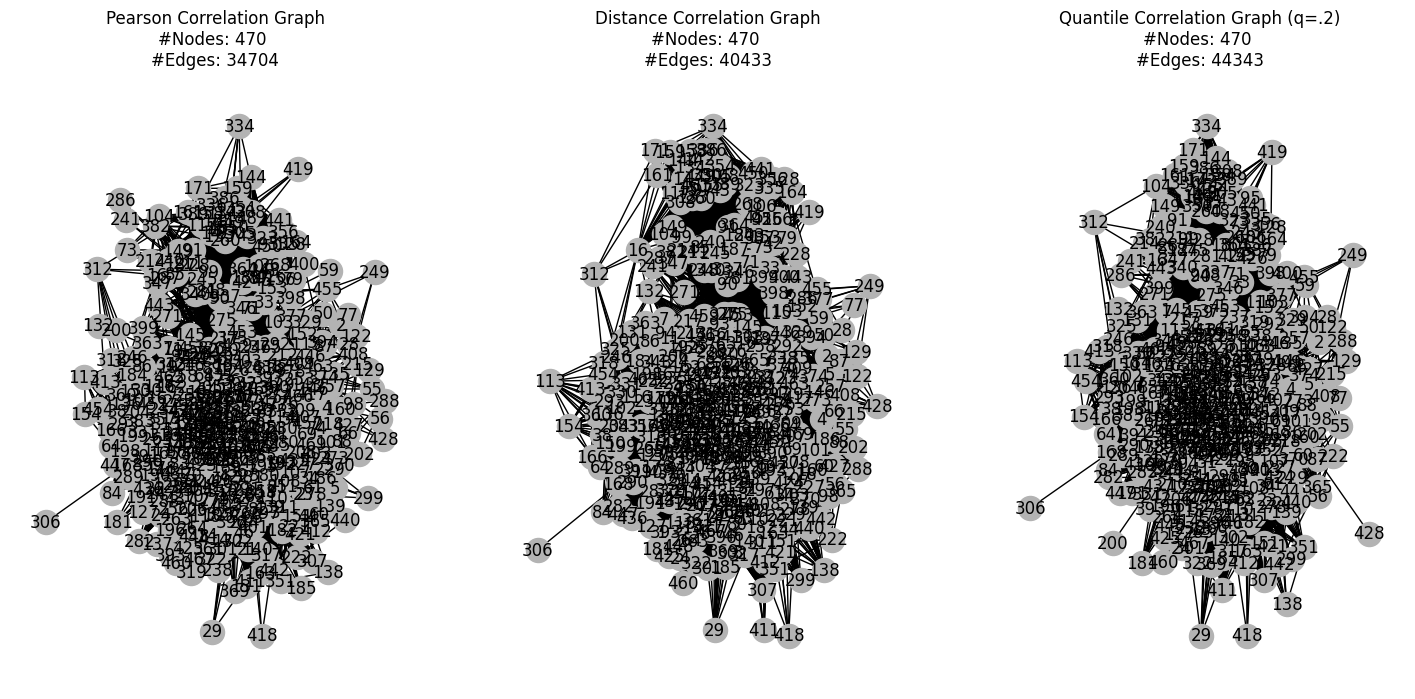

In [19]:
_, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, figsize=(18, 8))

# Pearson Graph
print("Plotting pearson graph...")
pos_pearson = nx.kamada_kawai_layout(nx_graph_pearson)
ax0.set_title(f"Pearson Correlation Graph\n#Nodes: {nx_graph_pearson.number_of_nodes()} \n" \
              f"#Edges: {nx_graph_pearson.number_of_edges()}")
nx.draw(nx_graph_pearson, pos_pearson, with_labels=True, node_color=[[.7, .7, .7]], ax=ax0)

# Distance Correlation Graph
print("Plotting distance correlation graph...")
pos_dcor = nx.kamada_kawai_layout(nx_graph_dcor)
ax1.set_title(f"Distance Correlation Graph\n#Nodes: {nx_graph_dcor.number_of_nodes()} \n" \
              f"#Edges: {nx_graph_dcor.number_of_edges()}")
nx.draw(nx_graph_dcor, pos_dcor, with_labels=True, node_color=[[.7, .7, .7]], ax=ax1)

# Quantile Correlation Graph (q=.2)
print("Plotting quantile graph (q=.2)...")
pos_quantile = nx.kamada_kawai_layout(nx_graph_quantile_02)
ax2.set_title(f"Quantile Correlation Graph (q=.2)\n#Nodes: {nx_graph_quantile_02.number_of_nodes()} \n" \
              f"#Edges: {nx_graph_quantile_02.number_of_edges()}")
nx.draw(nx_graph_quantile_02, pos_quantile, with_labels=True, node_color=[[.7, .7, .7]], ax=ax2)

## Set up GNN

- Original model from Schuetz et al. did not work well. 
- Hyperparameter Optimization done in notebook XXX
- Explain Architecture and Hyperparams

In [20]:
# best set of parameters according to 
# hyperparameter tuning

params = {'lr': 0.0001,
 'dim_embedding': 22,
 'hidden_dim': 11,
 'dropout': 0.05,
 'number_classes': 1,
 'prob_threshold': 0.5,
 'number_epochs': 25_000,
 'tolerance': 0.0001,
 'patience': 1000,
 'model': 'SAGE_2L_Model'}

In [21]:
assert graph_dgl_pearson.num_nodes() == graph_dgl_dcor.num_nodes()
assert graph_dgl_pearson.num_nodes() == graph_dgl_quantile_01.num_nodes()
assert graph_dgl_dcor.num_nodes() == graph_dgl_quantile_01.num_nodes()
assert graph_dgl_quantile_01.num_nodes() == graph_dgl_quantile_02.num_nodes()

In [22]:
n = nx_graph_pearson.number_of_nodes()

net, embed, optimizer = get_gnn(
    n_nodes=n,
    params=params, 
    model_type='SAGE_2L_Model', 
    torch_device=TORCH_DEVICE, 
    torch_dtype=TORCH_DTYPE)

net

SAGE_2L_Model(
  (conv1): SAGEConv(
    (feat_drop): Dropout(p=0.0, inplace=False)
    (fc_pool): Linear(in_features=22, out_features=22, bias=True)
    (fc_neigh): Linear(in_features=22, out_features=11, bias=False)
    (fc_self): Linear(in_features=22, out_features=11, bias=True)
  )
  (conv2): SAGEConv(
    (feat_drop): Dropout(p=0.0, inplace=False)
    (fc_pool): Linear(in_features=11, out_features=11, bias=True)
    (fc_neigh): Linear(in_features=11, out_features=1, bias=False)
    (fc_self): Linear(in_features=11, out_features=1, bias=True)
  )
)

## Run GNN training

In [23]:
training_inputs = [
    ('pearson', graph_dgl_pearson, q_torch_pearson, nx_graph_pearson),
    ('dcor', graph_dgl_dcor, q_torch_dcor, nx_graph_dcor),
    ('quantile_01', graph_dgl_quantile_01, q_torch_quantile_01, nx_graph_quantile_01),
    ('quantile_02', graph_dgl_quantile_02, q_torch_quantile_02, nx_graph_quantile_02),
    ('handcrafted', graph_dgl_handcrafted, q_torch_handcrafted, nx_graph_handcrafted)]

training_results = {}

for (name, dgl_graph, q_torch, nx_graph) in training_inputs:
    print(f"\nRunning GNN training for {name} graph...")

    gnn_start = time()
    
    net, embed, optimizer = get_gnn(
        n_nodes=n,
        params=params, 
        model_type='SAGE_2L_Model', 
        torch_device=TORCH_DEVICE, 
        torch_dtype=TORCH_DTYPE
    )
    
    net, epoch, final_bitstring, best_bitstring, best_loss, inputs, loss_hist, epoch_hist = run_gnn_training(
        q_torch=q_torch, 
        dgl_graph=dgl_graph, 
        net=net, 
        embed=embed, 
        optimizer=optimizer, 
        number_epochs=params['number_epochs']+1,
        tol=params['tolerance'], 
        patience=params['patience'], 
        prob_threshold=params['prob_threshold']
    )
    
    gnn_runtime = time() - gnn_start
    
    training_results[name] = {}
    training_results[name]['net'] = net
    training_results[name]['epoch'] = epoch
    training_results[name]['final_bitstring'] = final_bitstring
    training_results[name]['best_bitstring'] = best_bitstring
    training_results[name]['best_loss'] = best_loss.item()
    training_results[name]['loss_hist'] = loss_hist
    training_results[name]['epoch_hist'] = epoch_hist
    training_results[name]['gnn_runtime'] = gnn_runtime

    print(f"Graph post-processing...")
    final_loss = loss_func(final_bitstring.float(), q_torch)
    final_bitstring_str = ','.join([str(x) for x in final_bitstring])

    # Process bitstring reported by GNN
    size_mis_gnn, ind_set_gnn, number_violations_gnn = postprocess_gnn_mis(best_bitstring, nx_graph)

    training_results[name]['final_loss'] = final_loss.item()
    training_results[name]['size_mis_gnn'] = size_mis_gnn.item()
    training_results[name]['ind_set_gnn'] = ind_set_gnn
    training_results[name]['number_violations_gnn'] = number_violations_gnn




Running GNN training for pearson graph...
Epoch: 0, Loss: 13.506988525390625


Epoch: 1000, Loss: -18.7186336517334
Epoch: 2000, Loss: -30.70384979248047
Epoch: 3000, Loss: -33.18500518798828
Epoch: 4000, Loss: -34.66581344604492
Epoch: 5000, Loss: -35.464508056640625
Epoch: 6000, Loss: -52.166473388671875
Epoch: 7000, Loss: -57.99424362182617
Epoch: 8000, Loss: -64.52105712890625
Epoch: 9000, Loss: -71.61321258544922
Epoch: 10000, Loss: -74.48597717285156
Epoch: 11000, Loss: -74.69012451171875
Epoch: 12000, Loss: -74.95569610595703
Epoch: 13000, Loss: -74.94839477539062
Epoch: 14000, Loss: -76.71528625488281
Epoch: 15000, Loss: -76.97692108154297
Epoch: 16000, Loss: -76.99422454833984
Epoch: 17000, Loss: -76.9876937866211
Epoch: 18000, Loss: -76.96849060058594
Epoch: 19000, Loss: -76.92053985595703
Epoch: 20000, Loss: -78.98646545410156
Epoch: 21000, Loss: -79.36642456054688
Epoch: 22000, Loss: -79.99651336669922
Epoch: 23000, Loss: -79.99311065673828
Epoch: 24000, Loss: -79.94457244873047
Epoch: 25000, Loss: -79.9986343383789
GNN training (n=470) took 203.665
G

## Post-process GNN Results

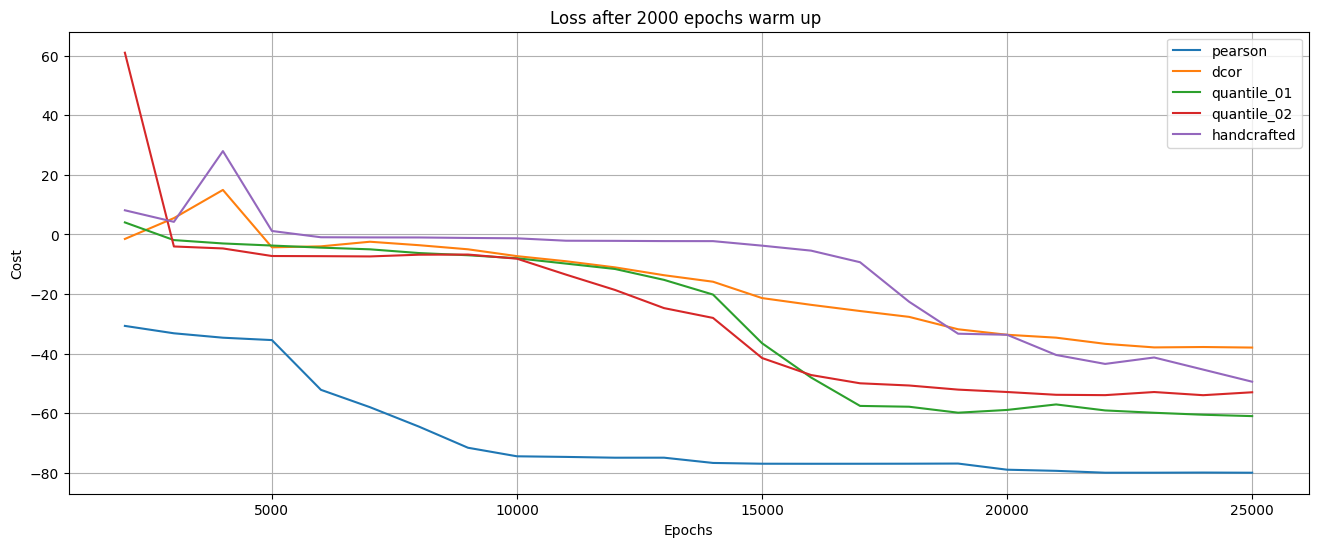

In [24]:
_, (ax0) = plt.subplots(nrows=1, ncols=1, figsize=(16, 6))

name = 'pearson'
tr_res_dict = training_results[name]
ax0.plot(tr_res_dict['epoch_hist'][2:], tr_res_dict['loss_hist'][2:] , label=name)

name = 'dcor'
tr_res_dict = training_results[name]
ax0.plot(tr_res_dict['epoch_hist'][2:], tr_res_dict['loss_hist'][2:] , label=name)

name = 'quantile_01'
tr_res_dict = training_results[name]
ax0.plot(tr_res_dict['epoch_hist'][2:], tr_res_dict['loss_hist'][2:] , label=name)

name = 'quantile_02'
tr_res_dict = training_results[name]
ax0.plot(tr_res_dict['epoch_hist'][2:], tr_res_dict['loss_hist'][2:] , label=name)

name = 'handcrafted'
tr_res_dict = training_results[name]
ax0.plot(tr_res_dict['epoch_hist'][2:], tr_res_dict['loss_hist'][2:] , label=name)

ax0.set_title("Loss after 2000 epochs warm up ")
ax0.set_ylabel("Cost")
ax0.set_xlabel("Epochs")
plt.grid()
plt.legend()
plt.show()

In [25]:
s = f"""
Pearson:
--------
    MIS size:       {training_results['pearson']['size_mis_gnn']}
    Violations:     {training_results['pearson']['number_violations_gnn']}
    Runtime (s):    {training_results['pearson']['gnn_runtime']:.1f}

Distance Correlation:
--------
    MIS size:       {training_results['dcor']['size_mis_gnn']}
    Violations:     {training_results['dcor']['number_violations_gnn']}
    Runtime (s):    {training_results['dcor']['gnn_runtime']:.1f}

Quantile Correlation (q=.1):
--------
    MIS size:       {training_results['quantile_01']['size_mis_gnn']}
    Violations:     {training_results['quantile_01']['number_violations_gnn']}
    Runtime (s):    {training_results['quantile_01']['gnn_runtime']:.1f}

Quantile Correlation (q=.2):
--------
    MIS size:       {training_results['quantile_02']['size_mis_gnn']}
    Violations:     {training_results['quantile_02']['number_violations_gnn']}
    Runtime (s):    {training_results['quantile_02']['gnn_runtime']:.1f}

Handcrafted:
--------
    MIS size:       {training_results['handcrafted']['size_mis_gnn']}
    Violations:     {training_results['handcrafted']['number_violations_gnn']}
    Runtime (s):    {training_results['handcrafted']['gnn_runtime']:.1f}
"""

print(s)


Pearson:
--------
    MIS size:       80
    Violations:     0
    Runtime (s):    203.7

Distance Correlation:
--------
    MIS size:       38
    Violations:     0
    Runtime (s):    226.0

Quantile Correlation (q=.1):
--------
    MIS size:       61
    Violations:     0
    Runtime (s):    244.4

Quantile Correlation (q=.2):
--------
    MIS size:       59
    Violations:     0
    Runtime (s):    246.4

Handcrafted:
--------
    MIS size:       49
    Violations:     9
    Runtime (s):    244.1



Plotting pearson graph...
Plotting dcor graph...
Plotting quantile_02 graph...


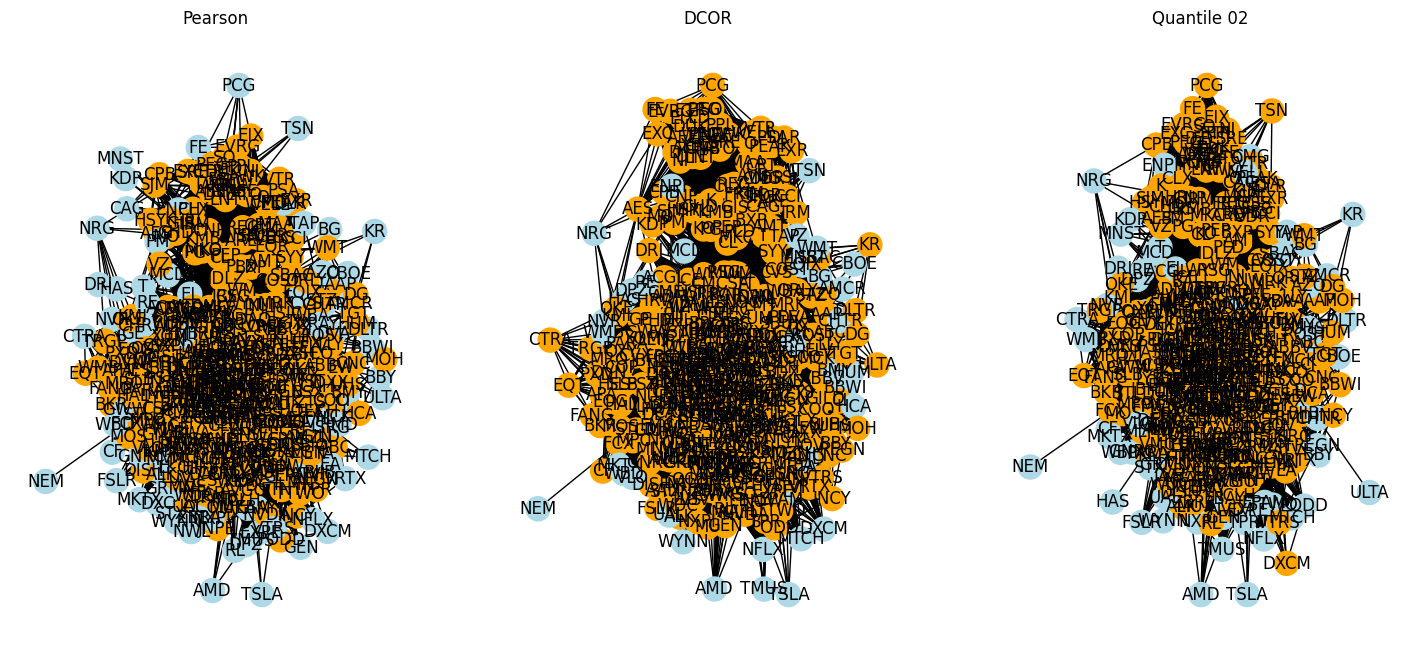

In [26]:
_, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, figsize=(18, 8))

# Pearson
name = 'pearson'
ax = ax0
print(f"Plotting {name} graph...")
best_bitstring = training_results[name]['best_bitstring']
gnn_mis_set_pearson = STOCK_NAMES[np.argwhere(best_bitstring == 1)].tolist()[0]

color_map = ['orange' if (best_bitstring[node]==0) else 'lightblue' for node in nx_graph_pearson.nodes]
nx_graph_labelled = nx.relabel_nodes(nx_graph_pearson, lambda x: STOCK_NAMES[x])
pos_labelled = nx.kamada_kawai_layout(nx_graph_labelled)

ax.set_title(f"{name.capitalize()}")
nx.draw(nx_graph_labelled, pos_labelled, with_labels=True, node_color=color_map, ax=ax)

# Distance Correlation
name = 'dcor'
ax = ax1
print(f"Plotting {name} graph...")
best_bitstring = training_results[name]['best_bitstring']
gnn_mis_set_dcor = STOCK_NAMES[np.argwhere(best_bitstring == 1)].tolist()[0]

color_map = ['orange' if (best_bitstring[node]==0) else 'lightblue' for node in nx_graph_dcor.nodes]
nx_graph_labelled = nx.relabel_nodes(nx_graph_dcor, lambda x: STOCK_NAMES[x])
pos_labelled = nx.kamada_kawai_layout(nx_graph_labelled)

ax.set_title(f"{name.upper()}")
nx.draw(nx_graph_labelled, pos_labelled, with_labels=True, node_color=color_map, ax=ax)

# Quantile (q=.2)
name = 'quantile_02'
ax = ax2
print(f"Plotting {name} graph...")
best_bitstring = training_results[name]['best_bitstring']
gnn_mis_set_quantile_02 = STOCK_NAMES[np.argwhere(best_bitstring == 1)].tolist()[0]

color_map = ['orange' if (best_bitstring[node]==0) else 'lightblue' for node in nx_graph_quantile_02.nodes]
nx_graph_labelled = nx.relabel_nodes(nx_graph_quantile_02, lambda x: STOCK_NAMES[x])
pos_labelled = nx.kamada_kawai_layout(nx_graph_labelled)

ax.set_title(f"{name.capitalize().replace('_', ' ')}")
nx.draw(nx_graph_labelled, pos_labelled, with_labels=True, node_color=color_map, ax=ax)

plt.show()

In [27]:
# Quantile (q=.1)
name = 'quantile_01'
best_bitstring = training_results[name]['best_bitstring']
gnn_mis_set_quantile_01 = STOCK_NAMES[np.argwhere(best_bitstring == 1)].tolist()[0]

# Handcrafted
name = 'handcrafted'
best_bitstring = training_results[name]['best_bitstring']
gnn_mis_set_handcrafted = STOCK_NAMES[np.argwhere(best_bitstring == 1)].tolist()[0]


In [28]:
n_intersec = len(set(gnn_mis_set_pearson) & set(gnn_mis_set_dcor) & set(gnn_mis_set_quantile_01) & \
                 set(gnn_mis_set_quantile_02) & set(gnn_mis_set_handcrafted))
s = f"""
Size of Intersection: {n_intersec}

Size Independent Set     | % of Intersction
-------------------------------------------
Pearson:         {len(gnn_mis_set_pearson)}     |  {(n_intersec / len(gnn_mis_set_pearson) * 100):.1f} %
DCOR:            {len(gnn_mis_set_dcor)}     |  {(n_intersec / len(gnn_mis_set_dcor) * 100):.1f} %
Quantile (q=.1): {len(gnn_mis_set_quantile_01)}     |  {(n_intersec / len(gnn_mis_set_quantile_01) * 100):.1f} %
Quantile (q=.2): {len(gnn_mis_set_quantile_02)}     |  {(n_intersec / len(gnn_mis_set_quantile_02) * 100):.1f} %
Handcrafted:     {len(gnn_mis_set_handcrafted)}     |  {(n_intersec / len(gnn_mis_set_handcrafted) * 100):.1f} %
"""
print(s)


Size of Intersection: 19

Size Independent Set     | % of Intersction
-------------------------------------------
Pearson:         80     |  23.8 %
DCOR:            38     |  50.0 %
Quantile (q=.1): 61     |  31.1 %
Quantile (q=.2): 59     |  32.2 %
Handcrafted:     49     |  38.8 %



## Compare against traditional solver

Here we compare the independent sets which were found by the GNN with independent sets of a traditional MIS solver. The Boppana-Halldorsson algorithm is a state of the art algorithm to approximate the maximal independent.

### Comparison of Pearson Correlation Graph 

Running built-in MIS solver (n=470).
Calculating violations...
Independence number found by nx solver is 74 with 0 violations.
MIS solver took 4.216s
Plotting pearson graph...


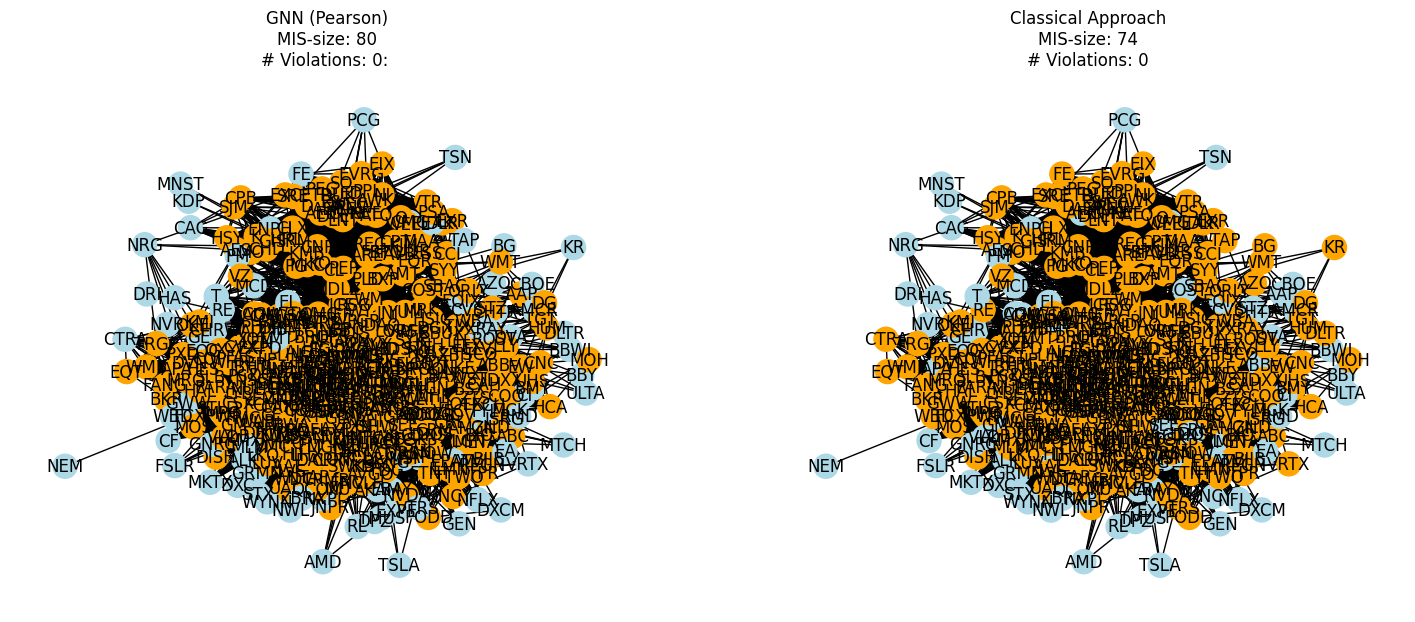

In [29]:
# run solver
print(f'Running built-in MIS solver (n={n}).')
start = time()
ind_set_bitstring_nx, ind_set_nx_size, number_violations_nx, t_solve = run_mis_solver(nx_graph_pearson)
end = time()
runtime_sol = end - start
print(f'Independence number found by nx solver is {ind_set_nx_size} with {number_violations_nx} violations.')
print(f'MIS solver took {round(runtime_sol, 3)}s')

solver_mis_set = STOCK_NAMES[np.argwhere(torch.tensor(ind_set_bitstring_nx) == 1)].tolist()[0]

_, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(18,7))

# Pearson
name = 'pearson'
ax = ax0
print(f"Plotting {name} graph...")
best_bitstring = training_results[name]['best_bitstring']
size_mis_gnn = training_results[name]['size_mis_gnn']
number_violations_gnn = training_results[name]['number_violations_gnn']

color_map = ['orange' if (best_bitstring[node]==0) else 'lightblue' for node in nx_graph_pearson.nodes]
nx_graph_labelled = nx.relabel_nodes(nx_graph_pearson, lambda x: STOCK_NAMES[x])
pos_labelled = nx.kamada_kawai_layout(nx_graph_labelled)

ax.set_title(f"GNN (Pearson)\nMIS-size: {size_mis_gnn}\n# Violations: {number_violations_gnn}: ")
nx.draw(nx_graph_labelled, pos_labelled, with_labels=True, node_color=color_map, ax=ax)

# MIS algo (classic approach)
color_map = ['orange' if (ind_set_bitstring_nx[node]==0) else 'lightblue' for node in nx_graph.nodes]
nx.draw(nx_graph_labelled, pos_labelled, with_labels=True, node_color=color_map, ax=ax1)
ax1.set_title(f"Classical Approach\nMIS-size: {ind_set_nx_size}\n# Violations: {number_violations_nx}")
plt.show()

### Comparison of Distance Correlation Graph 

Running built-in MIS solver (n=470).
Calculating violations...
Independence number found by nx solver is 48 with 0 violations.
MIS solver took 3.216s
Plotting dcor graph...


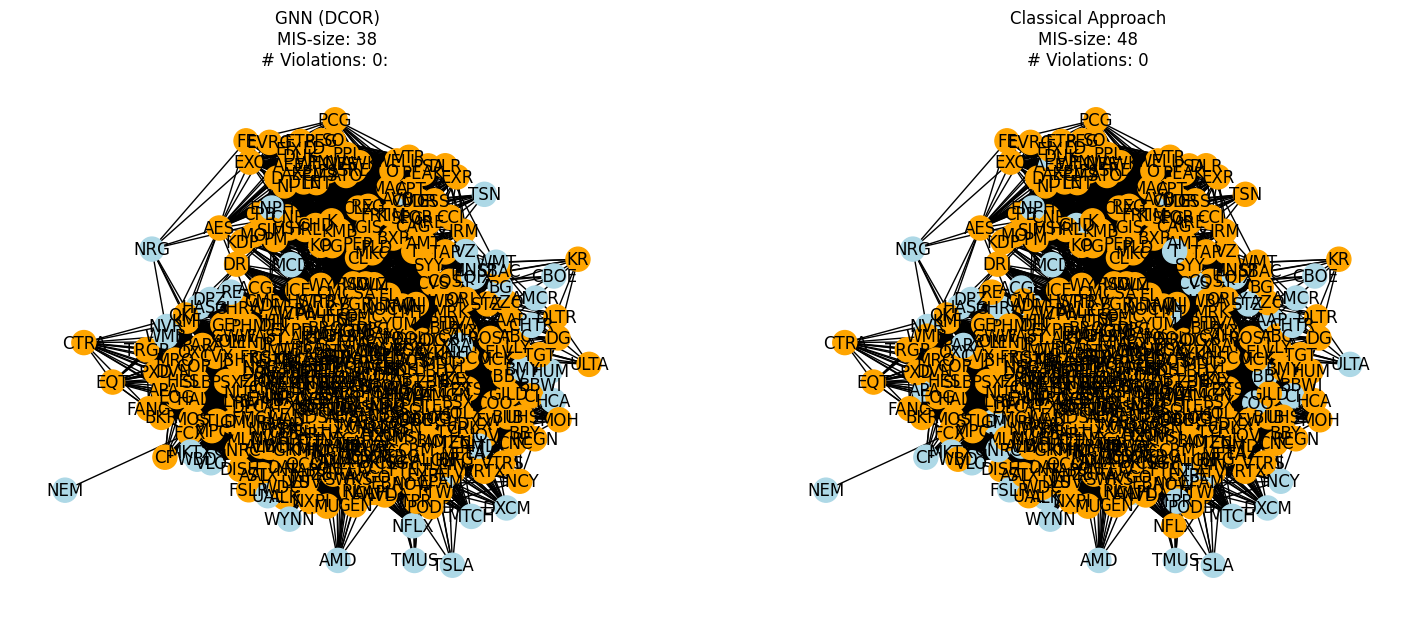

In [53]:
# run solver
print(f'Running built-in MIS solver (n={n}).')
start = time()
ind_set_bitstring_nx, ind_set_nx_size, number_violations_nx, t_solve = run_mis_solver(nx_graph_dcor)
end = time()
runtime_sol = end - start
print(f'Independence number found by nx solver is {ind_set_nx_size} with {number_violations_nx} violations.')
print(f'MIS solver took {round(runtime_sol, 3)}s')

solver_mis_set = STOCK_NAMES[np.argwhere(torch.tensor(ind_set_bitstring_nx) == 1)].tolist()[0]

_, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(18,7))

# DCOR
name = 'dcor'
ax = ax0
print(f"Plotting {name} graph...")
best_bitstring = training_results[name]['best_bitstring']
size_mis_gnn = training_results[name]['size_mis_gnn']
number_violations_gnn = training_results[name]['number_violations_gnn']

color_map = ['orange' if (best_bitstring[node]==0) else 'lightblue' for node in nx_graph_dcor.nodes]
nx_graph_labelled = nx.relabel_nodes(nx_graph_dcor, lambda x: STOCK_NAMES[x])
pos_labelled = nx.kamada_kawai_layout(nx_graph_labelled)

ax.set_title(f"GNN (DCOR)\nMIS-size: {size_mis_gnn}\n# Violations: {number_violations_gnn}: ")
nx.draw(nx_graph_labelled, pos_labelled, with_labels=True, node_color=color_map, ax=ax)

# MIS algo (classic approach)
color_map = ['orange' if (ind_set_bitstring_nx[node]==0) else 'lightblue' for node in nx_graph.nodes]
nx.draw(nx_graph_labelled, pos_labelled, with_labels=True, node_color=color_map, ax=ax1)
ax1.set_title(f"Classical Approach\nMIS-size: {ind_set_nx_size}\n# Violations: {number_violations_nx}")
plt.show()

### Comparison of Quantile Correlation Graph (q=.1)

Running built-in MIS solver (n=470).
Calculating violations...
Independence number found by nx solver is 59 with 0 violations.
MIS solver took 4.87s
Plotting quantile_01 graph...


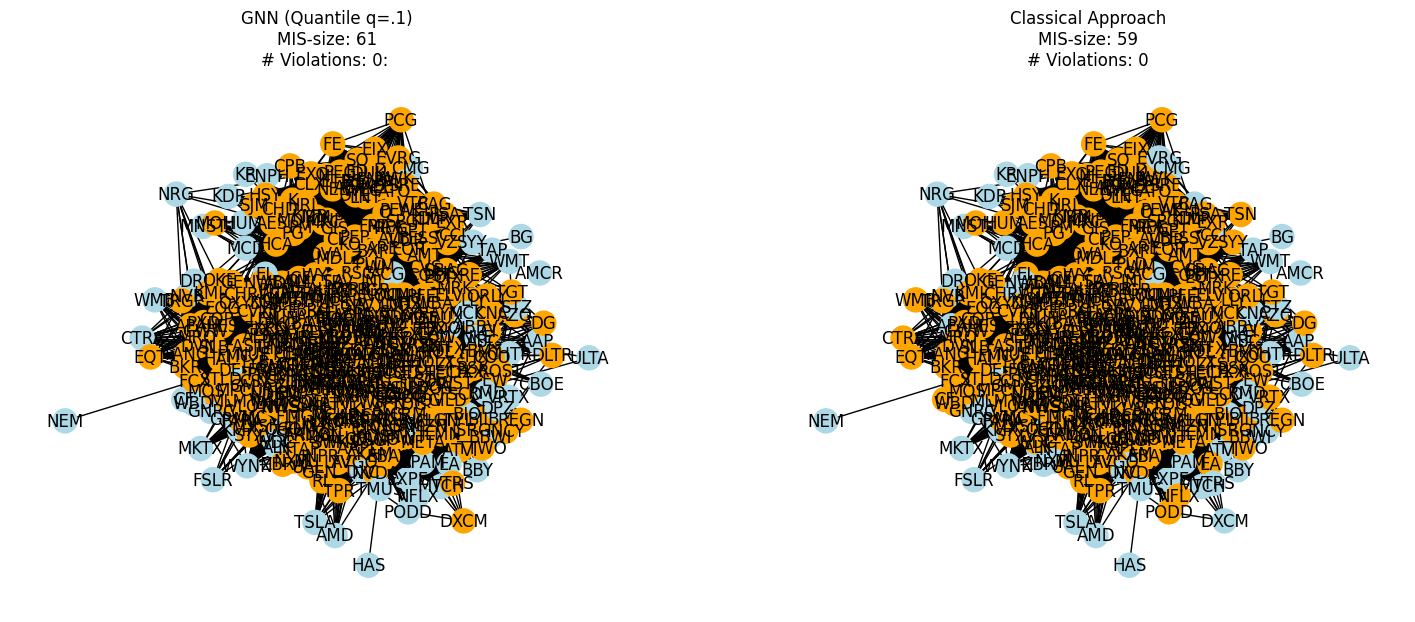

In [54]:
# run solver
print(f'Running built-in MIS solver (n={n}).')
start = time()
ind_set_bitstring_nx, ind_set_nx_size, number_violations_nx, t_solve = run_mis_solver(nx_graph_quantile_01)
end = time()
runtime_sol = end - start
print(f'Independence number found by nx solver is {ind_set_nx_size} with {number_violations_nx} violations.')
print(f'MIS solver took {round(runtime_sol, 3)}s')

solver_mis_set = STOCK_NAMES[np.argwhere(torch.tensor(ind_set_bitstring_nx) == 1)].tolist()[0]

_, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(18,7))

# Quantile (q=.1)
name = 'quantile_01'
ax = ax0
print(f"Plotting {name} graph...")
best_bitstring = training_results[name]['best_bitstring']
size_mis_gnn = training_results[name]['size_mis_gnn']
number_violations_gnn = training_results[name]['number_violations_gnn']

color_map = ['orange' if (best_bitstring[node]==0) else 'lightblue' for node in nx_graph_quantile_01.nodes]
nx_graph_labelled = nx.relabel_nodes(nx_graph_quantile_01, lambda x: STOCK_NAMES[x])
pos_labelled = nx.kamada_kawai_layout(nx_graph_labelled)

ax.set_title(f"GNN (Quantile q=.1)\nMIS-size: {size_mis_gnn}\n# Violations: {number_violations_gnn}: ")
nx.draw(nx_graph_labelled, pos_labelled, with_labels=True, node_color=color_map, ax=ax)

# MIS algo (classic approach)
color_map = ['orange' if (ind_set_bitstring_nx[node]==0) else 'lightblue' for node in nx_graph.nodes]
nx.draw(nx_graph_labelled, pos_labelled, with_labels=True, node_color=color_map, ax=ax1)
ax1.set_title(f"Classical Approach\nMIS-size: {ind_set_nx_size}\n# Violations: {number_violations_nx}")
plt.show()

### Comparison of Quantile Correlation Graph (q=.2)

Running built-in MIS solver (n=470).
Calculating violations...
Independence number found by nx solver is 57 with 0 violations.
MIS solver took 3.75s
Plotting quantile_02 graph...


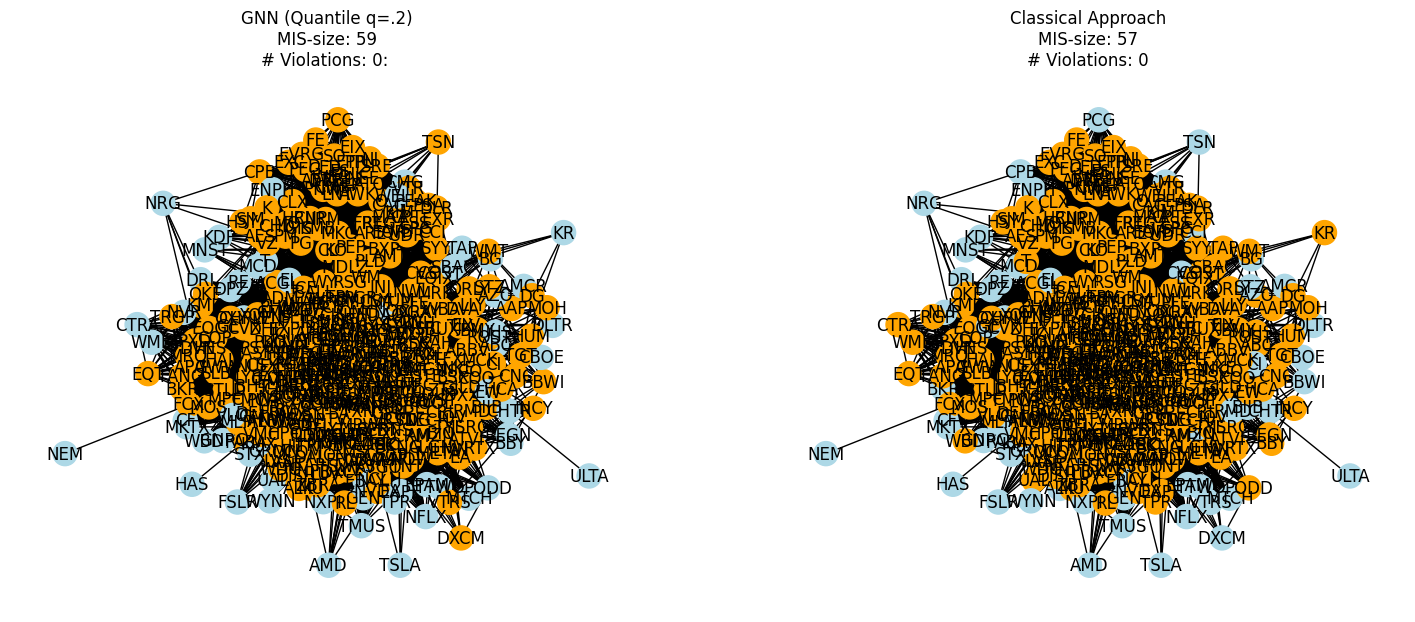

In [55]:
# run solver
print(f'Running built-in MIS solver (n={n}).')
start = time()
ind_set_bitstring_nx, ind_set_nx_size, number_violations_nx, t_solve = run_mis_solver(nx_graph_quantile_02)
end = time()
runtime_sol = end - start
print(f'Independence number found by nx solver is {ind_set_nx_size} with {number_violations_nx} violations.')
print(f'MIS solver took {round(runtime_sol, 3)}s')

solver_mis_set = STOCK_NAMES[np.argwhere(torch.tensor(ind_set_bitstring_nx) == 1)].tolist()[0]

_, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(18,7))

# Quantile (q=.2)
name = 'quantile_02'
ax = ax0
print(f"Plotting {name} graph...")
best_bitstring = training_results[name]['best_bitstring']
size_mis_gnn = training_results[name]['size_mis_gnn']
number_violations_gnn = training_results[name]['number_violations_gnn']

color_map = ['orange' if (best_bitstring[node]==0) else 'lightblue' for node in nx_graph_quantile_02.nodes]
nx_graph_labelled = nx.relabel_nodes(nx_graph_quantile_02, lambda x: STOCK_NAMES[x])
pos_labelled = nx.kamada_kawai_layout(nx_graph_labelled)

ax.set_title(f"GNN (Quantile q=.2)\nMIS-size: {size_mis_gnn}\n# Violations: {number_violations_gnn}: ")
nx.draw(nx_graph_labelled, pos_labelled, with_labels=True, node_color=color_map, ax=ax)

# MIS algo (classic approach)
color_map = ['orange' if (ind_set_bitstring_nx[node]==0) else 'lightblue' for node in nx_graph.nodes]
nx.draw(nx_graph_labelled, pos_labelled, with_labels=True, node_color=color_map, ax=ax1)
ax1.set_title(f"Classical Approach\nMIS-size: {ind_set_nx_size}\n# Violations: {number_violations_nx}")
plt.show()

## Backtest

In [33]:
def drawdown_pct(return_series):
    rs_max = return_series.rolling(
        window=len(return_series), 
        min_periods=1
        ).max()
    return return_series - rs_max

### Training

# stocks in pearson portfolio: 80
# stocks in dist. corr. portfolio: 38
# stocks in quantile portfolio: 61
# stocks in quantile portfolio: 59
# stocks in handcrafted portfolio: 49


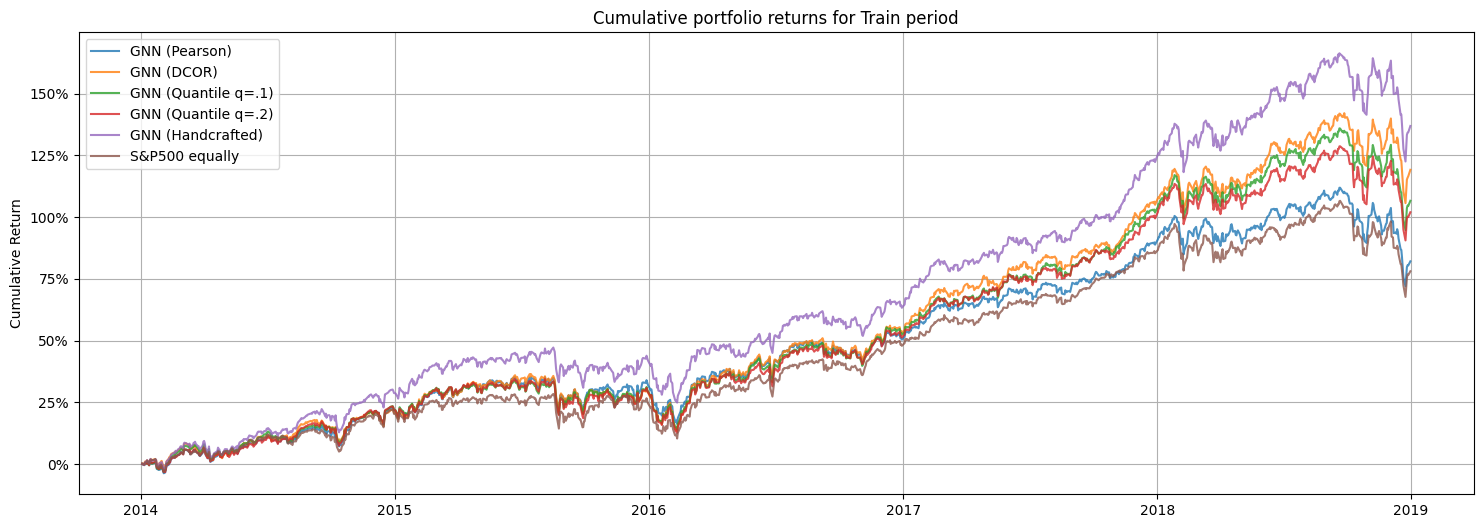

In [34]:
# GNN Pearson Portfolio
print(f"# stocks in pearson portfolio: {len(gnn_mis_set_pearson)}")
gnn_mis_pearson_returns_train, gnn_mis_pearson_returns_cum_train = portfolio_return(
    df=df_train,
    assets=gnn_mis_set_pearson
)

# GNN DCOR Portfolio
print(f"# stocks in dist. corr. portfolio: {len(gnn_mis_set_dcor)}")
gnn_mis_dcor_returns_train, gnn_mis_dcor_returns_cum_train = portfolio_return(
    df=df_train,
    assets=gnn_mis_set_dcor
)

# GNN Quantile (q=.1) Portfolio
print(f"# stocks in quantile portfolio: {len(gnn_mis_set_quantile_01)}")
gnn_mis_quantile_01_returns_train, gnn_mis_quantile_01_returns_cum_train = portfolio_return(
    df=df_train,
    assets=gnn_mis_set_quantile_01
)

# GNN Quantile (q=.2) Portfolio
print(f"# stocks in quantile portfolio: {len(gnn_mis_set_quantile_02)}")
gnn_mis_quantile_02_returns_train, gnn_mis_quantile_02_returns_cum_train = portfolio_return(
    df=df_train,
    assets=gnn_mis_set_quantile_02
)

# GNN Handcrafted Portfolio
print(f"# stocks in handcrafted portfolio: {len(gnn_mis_set_handcrafted)}")
gnn_mis_handcrafted_returns_train, gnn_mis_handcrafted_returns_cum_train = portfolio_return(
    df=df_train,
    assets=gnn_mis_set_handcrafted
)

# Benchmark all assets equally
gspc_equal_returns_train, gspc_equal_returns_cum_train = portfolio_return(
    df=df_train,
    assets=df_train.columns.to_list()
)

# Plot
_, ax = plt.subplots(figsize=(18,6))
alpha_value = 0.8

ax.plot(gnn_mis_pearson_returns_cum_train, label="GNN (Pearson)", alpha=alpha_value)
ax.plot(gnn_mis_dcor_returns_cum_train, label="GNN (DCOR)", alpha=alpha_value)
ax.plot(gnn_mis_quantile_01_returns_cum_train, label="GNN (Quantile q=.1)", alpha=alpha_value)
ax.plot(gnn_mis_quantile_02_returns_cum_train, label="GNN (Quantile q=.2)", alpha=alpha_value)
ax.plot(gnn_mis_handcrafted_returns_cum_train, label="GNN (Handcrafted)", alpha=alpha_value)
ax.plot(gspc_equal_returns_cum_train, label="S&P500 equally", alpha=alpha_value)
# ax.plot(gspc_random_p_returns_cum_train, label="S&P500 random", alpha=alpha_value)

ax.set_title("Cumulative portfolio returns for Train period")
ax.set_ylabel("Cumulative Return")
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 
ax.legend()
ax.grid()
plt.show()

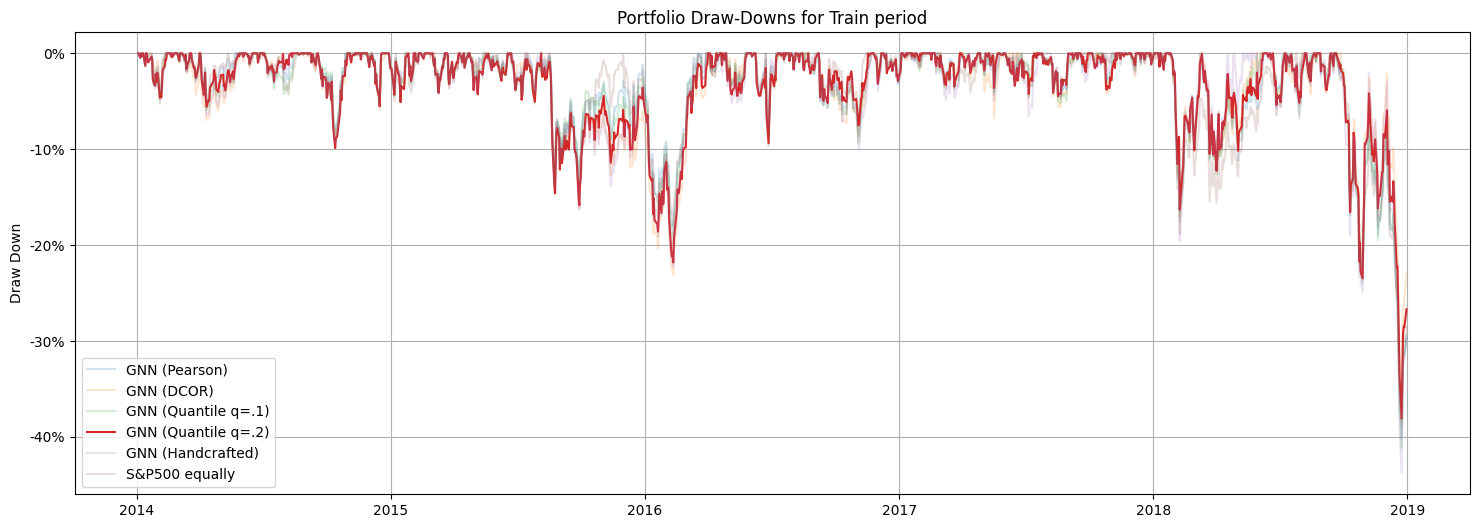

In [56]:
gnn_mis_pearson_mdd_train = drawdown_pct(gnn_mis_pearson_returns_cum_train)
gnn_mis_dcor_mdd_train = drawdown_pct(gnn_mis_dcor_returns_cum_train)
gnn_mis_handcrafted_mdd_train = drawdown_pct(gnn_mis_handcrafted_returns_cum_train)
gnn_mis_quantile_01_mdd_train = drawdown_pct(gnn_mis_quantile_01_returns_cum_train)
gnn_mis_quantile_02_mdd_train = drawdown_pct(gnn_mis_quantile_02_returns_cum_train)

gspc_equal_mdd_train = drawdown_pct(gspc_equal_returns_cum_train)

# Plot
alpha_value = 0.2
alpha_value_q = 1.0

_, ax = plt.subplots(figsize=(18,6))

ax.plot(gnn_mis_pearson_mdd_train, label="GNN (Pearson)", alpha=alpha_value)
ax.plot(gnn_mis_dcor_mdd_train, label="GNN (DCOR)", alpha=alpha_value)
ax.plot(gnn_mis_quantile_01_mdd_train, label="GNN (Quantile q=.1)", alpha=alpha_value)
ax.plot(gnn_mis_quantile_02_mdd_train, label="GNN (Quantile q=.2)", alpha=alpha_value_q)
ax.plot(gnn_mis_handcrafted_mdd_train, label="GNN (Handcrafted)", alpha=alpha_value)

ax.plot(gspc_equal_mdd_train, label="S&P500 equally", alpha=alpha_value)

ax.set_title("Portfolio Draw-Downs for Train period")
ax.set_ylabel("Draw Down")
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 
ax.legend()
ax.grid()
plt.show()

In [36]:
# Sharpe Ratios
df_sharpe_train = pd.concat([
    annualized_sharpe_ratio(df_returns=gnn_mis_pearson_returns_train, risk_free_rate=RISK_FREE_RATE, name='GNN (Pearson)'),
    annualized_sharpe_ratio(df_returns=gnn_mis_dcor_returns_train, risk_free_rate=RISK_FREE_RATE, name='GNN (DCOR)'),
    annualized_sharpe_ratio(df_returns=gnn_mis_quantile_01_returns_train, risk_free_rate=RISK_FREE_RATE, name='GNN (Quantile q=.1)'),
    annualized_sharpe_ratio(df_returns=gnn_mis_quantile_02_returns_train, risk_free_rate=RISK_FREE_RATE, name='GNN (Quantile q=.2)'),
    annualized_sharpe_ratio(df_returns=gnn_mis_handcrafted_returns_train, risk_free_rate=RISK_FREE_RATE, name='GNN (Handcrafted)'),
    annualized_sharpe_ratio(df_returns=gspc_equal_returns_train, risk_free_rate=RISK_FREE_RATE, name='S&P500 equally')
], axis=1).T

df_sharpe_train['Avg'] = df_sharpe_train.mean(axis=1)
df_sharpe_train.columns.rename('', inplace=True)
multi_idx = np.array([['Sharpe']*len(df_sharpe_train.index), df_sharpe_train.index.values])
multi_idx = pd.MultiIndex.from_arrays(multi_idx, names=('Metric', 'Portfolio'))
df_sharpe_train.index = multi_idx
df_sharpe_train.round(2)

2014  2015  2016  2017  2018   Avg
Metric Portfolio                                              
Sharpe GNN (Pearson)        1.59  0.58  0.92  2.77 -0.22  1.13
       GNN (DCOR)           1.47  0.45  1.15  3.29  0.44  1.36
       GNN (Quantile q=.1)  1.58  0.41  1.12  3.25  0.16  1.30
       GNN (Quantile q=.2)  1.56  0.39  1.05  3.30  0.09  1.28
       GNN (Handcrafted)    1.95  0.66  0.96  3.47  0.41  1.49
       S&P500 equally       1.53  0.24  1.18  3.06 -0.24  1.15

In [37]:
# Sortino Ratios
df_sortino_train = pd.concat([
    annualized_sortino_ratio(df_returns=gnn_mis_pearson_returns_train, risk_free_rate=RISK_FREE_RATE, name='GNN (Pearson)'),
    annualized_sortino_ratio(df_returns=gnn_mis_dcor_returns_train, risk_free_rate=RISK_FREE_RATE, name='GNN (DCOR)'),
    annualized_sortino_ratio(df_returns=gnn_mis_quantile_01_returns_train, risk_free_rate=RISK_FREE_RATE, name='GNN (Quantile q=.1)'),
    annualized_sortino_ratio(df_returns=gnn_mis_quantile_02_returns_train, risk_free_rate=RISK_FREE_RATE, name='GNN (Quantile q=.2)'),
    annualized_sortino_ratio(df_returns=gnn_mis_handcrafted_returns_train, risk_free_rate=RISK_FREE_RATE, name='GNN (Handcrafted)'),
    annualized_sortino_ratio(df_returns=gspc_equal_returns_train, risk_free_rate=RISK_FREE_RATE, name='S&P500 equally'),

], axis=1).T

df_sortino_train['Avg'] = df_sortino_train.mean(axis=1)
df_sortino_train.columns.rename('', inplace=True)
multi_idx = np.array([['Sortino']*len(df_sortino_train.index), df_sortino_train.index.values])
multi_idx = pd.MultiIndex.from_arrays(multi_idx, names=('Metric', 'Portfolio'))
df_sortino_train.index = multi_idx
df_sortino_train.round(2)

2014  2015  2016  2017  2018   Avg
Metric  Portfolio                                              
Sortino GNN (Pearson)        2.09  0.84  1.24  4.00 -0.29  1.58
        GNN (DCOR)           2.01  0.66  1.52  4.75  0.59  1.91
        GNN (Quantile q=.1)  2.09  0.59  1.55  4.83  0.22  1.85
        GNN (Quantile q=.2)  2.09  0.55  1.39  4.70  0.12  1.77
        GNN (Handcrafted)    2.58  0.97  1.33  5.19  0.54  2.12
        S&P500 equally       2.02  0.34  1.52  4.34 -0.30  1.58

In [38]:
# Maximal Draw Down
df_mdd_train = pd.concat([
    annualized_max_drawdown(df_returns=gnn_mis_pearson_returns_train, name='GNN (Pearson)'),
    annualized_max_drawdown(df_returns=gnn_mis_dcor_returns_train, name='GNN (DCOR)'),
    annualized_max_drawdown(df_returns=gnn_mis_quantile_01_returns_train, name='GNN (Quantile q=.1)'),
    annualized_max_drawdown(df_returns=gnn_mis_quantile_02_returns_train, name='GNN (Quantile q=.2)'),
    annualized_max_drawdown(df_returns=gnn_mis_handcrafted_returns_train, name='GNN (Handcrafted)'),
    annualized_max_drawdown(df_returns=gspc_equal_returns_train, name='S&P500 equally')
], axis=1).T

df_mdd_train['Avg'] = df_mdd_train.mean(axis=1)
df_mdd_train.columns.rename('', inplace=True)
multi_idx = np.array([['MDD']*len(df_mdd_train.index), df_mdd_train.index.values])
multi_idx = pd.MultiIndex.from_arrays(multi_idx, names=('Metric', 'Portfolio'))
df_mdd_train.index = multi_idx
df_mdd_train.round(2)

2014  2015  2016  2017  2018   Avg
Metric Portfolio                                              
MDD    GNN (Pearson)       -0.08 -0.14 -0.19 -0.05 -0.40 -0.17
       GNN (DCOR)          -0.09 -0.16 -0.23 -0.07 -0.36 -0.18
       GNN (Quantile q=.1) -0.08 -0.14 -0.20 -0.05 -0.41 -0.18
       GNN (Quantile q=.2) -0.10 -0.16 -0.22 -0.04 -0.38 -0.18
       GNN (Handcrafted)   -0.09 -0.16 -0.22 -0.07 -0.44 -0.20
       S&P500 equally      -0.09 -0.14 -0.18 -0.04 -0.39 -0.17

In [39]:
# Calmar Ratios
df_calmar_train = pd.concat([
    annualized_calmar_ratio(df_returns=gnn_mis_pearson_returns_train, risk_free_rate=RISK_FREE_RATE, name='GNN (Pearson)'),
    annualized_calmar_ratio(df_returns=gnn_mis_dcor_returns_train, risk_free_rate=RISK_FREE_RATE, name='GNN (DCOR)'),
    annualized_calmar_ratio(df_returns=gnn_mis_quantile_01_returns_train, risk_free_rate=RISK_FREE_RATE, name='GNN (Quantile q=.1)'),
    annualized_calmar_ratio(df_returns=gnn_mis_quantile_02_returns_train, risk_free_rate=RISK_FREE_RATE, name='GNN (Quantile q=.2)'),
    annualized_calmar_ratio(df_returns=gnn_mis_handcrafted_returns_train, risk_free_rate=RISK_FREE_RATE, name='GNN (Handcrafted)'),
    annualized_calmar_ratio(df_returns=gspc_equal_returns_train, risk_free_rate=RISK_FREE_RATE, name='S&P500 equally'),
], axis=1).T

df_calmar_train['Avg'] = df_calmar_train.mean(axis=1)
df_calmar_train.columns.rename('', inplace=True)
multi_idx = np.array([['Calmar']*len(df_calmar_train.index), df_calmar_train.index.values])
multi_idx = pd.MultiIndex.from_arrays(multi_idx, names=('Metric', 'Portfolio'))
df_calmar_train.index = multi_idx
df_calmar_train.round(2)

2014  2015  2016  2017  2018   Avg
Metric Portfolio                                              
Calmar GNN (Pearson)        2.31  0.62  0.69  4.68 -0.09  1.64
       GNN (DCOR)           2.09  0.42  0.75  4.20  0.19  1.53
       GNN (Quantile q=.1)  2.39  0.44  0.82  5.25  0.06  1.79
       GNN (Quantile q=.2)  1.98  0.38  0.73  6.05  0.04  1.84
       GNN (Handcrafted)    2.67  0.61  0.63  4.60  0.15  1.73
       S&P500 equally       2.01  0.26  0.95  5.22 -0.10  1.67

### Validation

# stocks in pearson portfolio: 80
# stocks in dist. corr. portfolio: 38
# stocks in handcrafted portfolio: 49
# stocks in dist. corr. portfolio: 61
# stocks in dist. corr. portfolio: 59


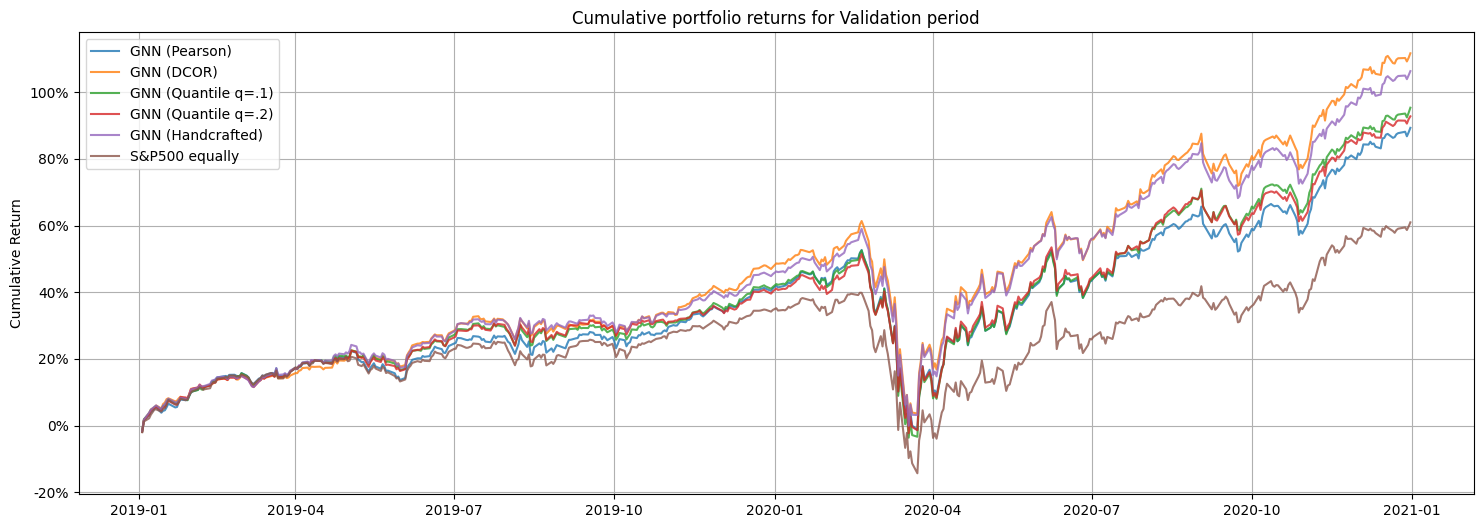

In [40]:
# GNN Pearson Portfolio
print(f"# stocks in pearson portfolio: {len(gnn_mis_set_pearson)}")
gnn_mis_pearson_returns_val, gnn_mis_pearson_returns_cum_val = portfolio_return(
    df=df_val,
    assets=gnn_mis_set_pearson
)

# GNN DCOR Portfolio
print(f"# stocks in dist. corr. portfolio: {len(gnn_mis_set_dcor)}")
gnn_mis_dcor_returns_val, gnn_mis_dcor_returns_cum_val = portfolio_return(
    df=df_val,
    assets=gnn_mis_set_dcor
)

# GNN Handcrafted Portfolio
print(f"# stocks in handcrafted portfolio: {len(gnn_mis_set_handcrafted)}")
gnn_mis_handcrafted_returns_val, gnn_mis_handcrafted_returns_cum_val = portfolio_return(
    df=df_val,
    assets=gnn_mis_set_handcrafted
)

# GNN Quantile Portfolio q=.1
print(f"# stocks in dist. corr. portfolio: {len(gnn_mis_set_quantile_01)}")
gnn_mis_quantile_01_returns_val, gnn_mis_quantile_01_returns_cum_val = portfolio_return(
    df=df_val,
    assets=gnn_mis_set_quantile_01
)

# GNN Quantile Portfolio q=.2
print(f"# stocks in dist. corr. portfolio: {len(gnn_mis_set_quantile_02)}")
gnn_mis_quantile_02_returns_val, gnn_mis_quantile_02_returns_cum_val = portfolio_return(
    df=df_val,
    assets=gnn_mis_set_quantile_02
)

# Benchmark all assets equally
gspc_equal_returns_val, gspc_equal_returns_cum_val = portfolio_return(
    df=df_val,
    assets=df_val.columns.to_list()
)

# Plot
alpha_value = 0.8
_, ax = plt.subplots(figsize=(18,6))

ax.plot(gnn_mis_pearson_returns_cum_val, label="GNN (Pearson)", alpha=alpha_value)
ax.plot(gnn_mis_dcor_returns_cum_val, label="GNN (DCOR)", alpha=alpha_value)
ax.plot(gnn_mis_quantile_01_returns_cum_val, label="GNN (Quantile q=.1)", alpha=alpha_value)
ax.plot(gnn_mis_quantile_02_returns_cum_val, label="GNN (Quantile q=.2)", alpha=alpha_value)
ax.plot(gnn_mis_handcrafted_returns_cum_val, label="GNN (Handcrafted)", alpha=alpha_value)
ax.plot(gspc_equal_returns_cum_val, label="S&P500 equally", alpha=alpha_value)

ax.set_title("Cumulative portfolio returns for Validation period")
ax.set_ylabel("Cumulative Return")
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 
ax.legend()
ax.grid()
plt.show()

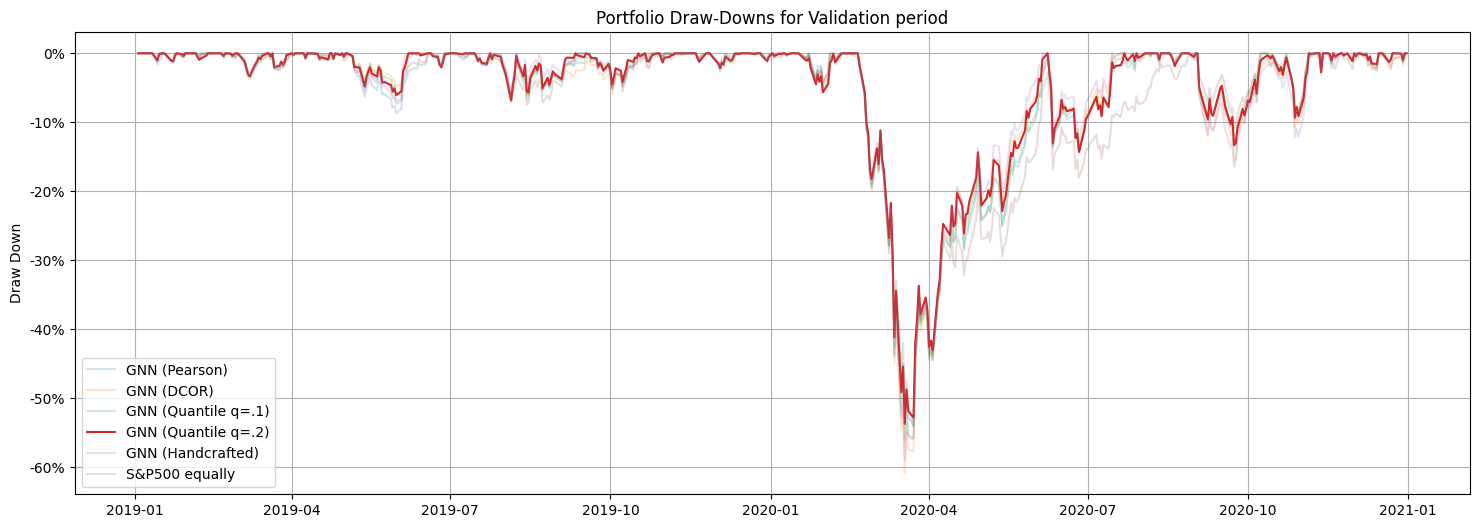

In [41]:
gnn_mis_pearson_mdd_val = drawdown_pct(gnn_mis_pearson_returns_cum_val)
gnn_mis_dcor_mdd_val = drawdown_pct(gnn_mis_dcor_returns_cum_val)
gnn_mis_handcrafted_mdd_val = drawdown_pct(gnn_mis_handcrafted_returns_cum_val)
gnn_mis_quantile_01_mdd_val = drawdown_pct(gnn_mis_quantile_01_returns_cum_val)
gnn_mis_quantile_02_mdd_val = drawdown_pct(gnn_mis_quantile_02_returns_cum_val)
gspc_equal_mdd_val = drawdown_pct(gspc_equal_returns_cum_val)

# Plot
alpha_value = 0.2
alpha_value_q = 1.0
_, ax = plt.subplots(figsize=(18,6))

ax.plot(gnn_mis_pearson_mdd_val, label="GNN (Pearson)", alpha=alpha_value)
ax.plot(gnn_mis_dcor_mdd_val, label="GNN (DCOR)", alpha=alpha_value)
ax.plot(gnn_mis_quantile_01_mdd_val, label="GNN (Quantile q=.1)", alpha=alpha_value)
ax.plot(gnn_mis_quantile_02_mdd_val, label="GNN (Quantile q=.2)", alpha=alpha_value_q)
ax.plot(gnn_mis_handcrafted_mdd_val, label="GNN (Handcrafted)", alpha=alpha_value)
ax.plot(gspc_equal_mdd_val, label="S&P500 equally", alpha=alpha_value)

ax.set_title("Portfolio Draw-Downs for Validation period")
ax.set_ylabel("Draw Down")
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 
ax.legend()
ax.grid()
plt.show()

In [42]:
# Sharpe Ratios
df_sharpe_val = pd.concat([
    annualized_sharpe_ratio(df_returns=gnn_mis_pearson_returns_val, risk_free_rate=RISK_FREE_RATE, name='GNN (Pearson)'),
    annualized_sharpe_ratio(df_returns=gnn_mis_dcor_returns_val, risk_free_rate=RISK_FREE_RATE, name='GNN (DCOR)'),
    annualized_sharpe_ratio(df_returns=gnn_mis_quantile_01_returns_val, risk_free_rate=RISK_FREE_RATE, name='GNN (Quantile q=.1)'),
    annualized_sharpe_ratio(df_returns=gnn_mis_quantile_02_returns_val, risk_free_rate=RISK_FREE_RATE, name='GNN (Quantile q=.2)'),
    annualized_sharpe_ratio(df_returns=gnn_mis_handcrafted_returns_val, risk_free_rate=RISK_FREE_RATE, name='GNN (Handcrafted)'),
    annualized_sharpe_ratio(df_returns=gspc_equal_returns_val, risk_free_rate=RISK_FREE_RATE, name='S&P500 equally')
], axis=1).T

df_sharpe_val['Avg'] = df_sharpe_val.mean(axis=1)
df_sharpe_val.columns.rename('', inplace=True)
multi_idx = np.array([['Sharpe']*len(df_sharpe_val.index), df_sharpe_val.index.values])
multi_idx = pd.MultiIndex.from_arrays(multi_idx, names=('Metric', 'Portfolio'))
df_sharpe_val.index = multi_idx
df_sharpe_val.round(2)

2019  2020   Avg
Metric Portfolio                            
Sharpe GNN (Pearson)        2.65  1.00  1.82
       GNN (DCOR)           3.13  1.16  2.15
       GNN (Quantile q=.1)  2.77  1.05  1.91
       GNN (Quantile q=.2)  2.69  1.06  1.87
       GNN (Handcrafted)    2.92  1.14  2.03
       S&P500 equally       2.37  0.63  1.50

In [43]:
# Sortino Ratios
df_sortino_val = pd.concat([
    annualized_sortino_ratio(df_returns=gnn_mis_pearson_returns_val, risk_free_rate=RISK_FREE_RATE, name='GNN (Pearson)'),
    annualized_sortino_ratio(df_returns=gnn_mis_dcor_returns_val, risk_free_rate=RISK_FREE_RATE, name='GNN (DCOR)'),
    annualized_sortino_ratio(df_returns=gnn_mis_quantile_01_returns_val, risk_free_rate=RISK_FREE_RATE, name='GNN (Quantile q=.1)'),
    annualized_sortino_ratio(df_returns=gnn_mis_quantile_02_returns_val, risk_free_rate=RISK_FREE_RATE, name='GNN (Quantile q=.2)'),
    annualized_sortino_ratio(df_returns=gnn_mis_handcrafted_returns_val, risk_free_rate=RISK_FREE_RATE, name='GNN (Handcrafted)'),
    annualized_sortino_ratio(df_returns=gspc_equal_returns_val, risk_free_rate=RISK_FREE_RATE, name='S&P500 equally'),
], axis=1).T

df_sortino_val['Avg'] = df_sortino_val.mean(axis=1)
df_sortino_val.columns.rename('', inplace=True)
multi_idx = np.array([['Sortino']*len(df_sortino_val.index), df_sortino_val.index.values])
multi_idx = pd.MultiIndex.from_arrays(multi_idx, names=('Metric', 'Portfolio'))
df_sortino_val.index = multi_idx
df_sortino_val.round(2)

2019  2020   Avg
Metric  Portfolio                            
Sortino GNN (Pearson)        3.52  1.09  2.30
        GNN (DCOR)           4.15  1.25  2.70
        GNN (Quantile q=.1)  3.77  1.13  2.45
        GNN (Quantile q=.2)  3.68  1.15  2.42
        GNN (Handcrafted)    4.09  1.23  2.66
        S&P500 equally       3.01  0.73  1.87

In [44]:
# Maximal Draw Down
df_mdd_val = pd.concat([
    annualized_max_drawdown(df_returns=gnn_mis_pearson_returns_val, name='GNN (Pearson)'),
    annualized_max_drawdown(df_returns=gnn_mis_dcor_returns_val, name='GNN (DCOR)'),
    annualized_max_drawdown(df_returns=gnn_mis_quantile_01_returns_val, name='GNN (Quantile q=.1)'),
    annualized_max_drawdown(df_returns=gnn_mis_quantile_02_returns_val, name='GNN (Quantile q=.2)'),
    annualized_max_drawdown(df_returns=gnn_mis_handcrafted_returns_val, name='GNN (Handcrafted)'),
    annualized_max_drawdown(df_returns=gspc_equal_returns_val, name='S&P500 equally')
], axis=1).T

df_mdd_val['Avg'] = df_mdd_val.mean(axis=1)
df_mdd_val.columns.rename('', inplace=True)
multi_idx = np.array([['MDD']*len(df_mdd_val.index), df_mdd_val.index.values])
multi_idx = pd.MultiIndex.from_arrays(multi_idx, names=('Metric', 'Portfolio'))
df_mdd_val.index = multi_idx
df_mdd_val.round(2)

2019  2020   Avg
Metric Portfolio                            
MDD    GNN (Pearson)       -0.09 -0.54 -0.31
       GNN (DCOR)          -0.07 -0.61 -0.34
       GNN (Quantile q=.1) -0.07 -0.56 -0.31
       GNN (Quantile q=.2) -0.07 -0.54 -0.30
       GNN (Handcrafted)   -0.07 -0.59 -0.33
       S&P500 equally      -0.07 -0.54 -0.31

In [45]:
# Calmar Ratios
df_calmar_val = pd.concat([
    annualized_calmar_ratio(df_returns=gnn_mis_pearson_returns_val, risk_free_rate=RISK_FREE_RATE, name='GNN (Pearson)'),
    annualized_calmar_ratio(df_returns=gnn_mis_dcor_returns_val, risk_free_rate=RISK_FREE_RATE, name='GNN (DCOR)'),
    annualized_calmar_ratio(df_returns=gnn_mis_quantile_01_returns_val, risk_free_rate=RISK_FREE_RATE, name='GNN (Quantile q=.1)'),
    annualized_calmar_ratio(df_returns=gnn_mis_quantile_02_returns_val, risk_free_rate=RISK_FREE_RATE, name='GNN (Quantile q=.2)'),
    annualized_calmar_ratio(df_returns=gnn_mis_handcrafted_returns_val, risk_free_rate=RISK_FREE_RATE, name='GNN (Handcrafted)'),
    annualized_calmar_ratio(df_returns=gspc_equal_returns_val, risk_free_rate=RISK_FREE_RATE, name='S&P500 equally'),
], axis=1).T

df_calmar_val['Avg'] = df_calmar_val.mean(axis=1)
df_calmar_val.columns.rename('', inplace=True)
multi_idx = np.array([['Calmar']*len(df_calmar_val.index), df_calmar_val.index.values])
multi_idx = pd.MultiIndex.from_arrays(multi_idx, names=('Metric', 'Portfolio'))
df_calmar_val.index = multi_idx
df_calmar_val.round(2)

2019  2020   Avg
Metric Portfolio                            
Calmar GNN (Pearson)        3.95  0.64  2.29
       GNN (DCOR)           5.60  0.68  3.14
       GNN (Quantile q=.1)  5.19  0.67  2.93
       GNN (Quantile q=.2)  4.93  0.69  2.81
       GNN (Handcrafted)    5.41  0.68  3.04
       S&P500 equally       3.97  0.45  2.21

### Test

# stocks in pearson portfolio: 80
# stocks in dist. corr. portfolio: 38
# stocks in handcrafted portfolio: 49
# stocks in dist. corr. portfolio: 61
# stocks in dist. corr. portfolio: 59


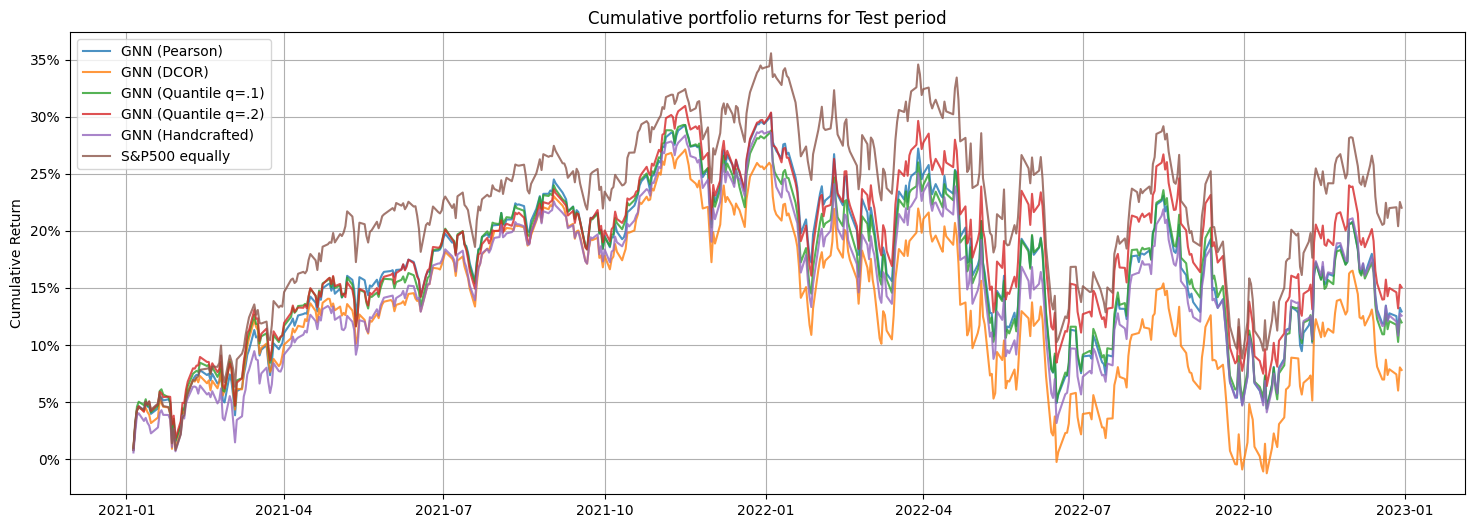

In [46]:
# GNN Pearson Portfolio
print(f"# stocks in pearson portfolio: {len(gnn_mis_set_pearson)}")
gnn_mis_pearson_returns_test, gnn_mis_pearson_returns_cum_test = portfolio_return(
    df=df_test,
    assets=gnn_mis_set_pearson
)

# GNN DCOR Portfolio
print(f"# stocks in dist. corr. portfolio: {len(gnn_mis_set_dcor)}")
gnn_mis_dcor_returns_test, gnn_mis_dcor_returns_cum_test = portfolio_return(
    df=df_test,
    assets=gnn_mis_set_dcor
)

# GNN Handcrafted Portfolio
print(f"# stocks in handcrafted portfolio: {len(gnn_mis_set_handcrafted)}")
gnn_mis_handcrafted_returns_test, gnn_mis_handcrafted_returns_cum_test = portfolio_return(
    df=df_test,
    assets=gnn_mis_set_handcrafted
)

# GNN Quantile q=.1 Portfolio
print(f"# stocks in dist. corr. portfolio: {len(gnn_mis_set_quantile_01)}")
gnn_mis_quantile_01_returns_test, gnn_mis_quantile_01_returns_cum_test = portfolio_return(
    df=df_test,
    assets=gnn_mis_set_quantile_01
)

# GNN Quantile q=.2 Portfolio
print(f"# stocks in dist. corr. portfolio: {len(gnn_mis_set_quantile_02)}")
gnn_mis_quantile_02_returns_test, gnn_mis_quantile_02_returns_cum_test = portfolio_return(
    df=df_test,
    assets=gnn_mis_set_quantile_02
)

# Benchmark all assets equally
gspc_equal_returns_test, gspc_equal_returns_cum_test = portfolio_return(
    df=df_test,
    assets=df_test.columns.to_list())

# Plot
alpha_value = 0.8
_, ax = plt.subplots(figsize=(18,6))

ax.plot(gnn_mis_pearson_returns_cum_test, label="GNN (Pearson)", alpha=alpha_value)
ax.plot(gnn_mis_dcor_returns_cum_test, label="GNN (DCOR)", alpha=alpha_value)
ax.plot(gnn_mis_quantile_01_returns_cum_test, label="GNN (Quantile q=.1)", alpha=alpha_value)
ax.plot(gnn_mis_quantile_02_returns_cum_test, label="GNN (Quantile q=.2)", alpha=alpha_value)
ax.plot(gnn_mis_handcrafted_returns_cum_test, label="GNN (Handcrafted)", alpha=alpha_value)
ax.plot(gspc_equal_returns_cum_test, label="S&P500 equally", alpha=alpha_value)

ax.set_title("Cumulative portfolio returns for Test period")
ax.set_ylabel("Cumulative Return")
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 
ax.legend()
ax.grid()
plt.show()

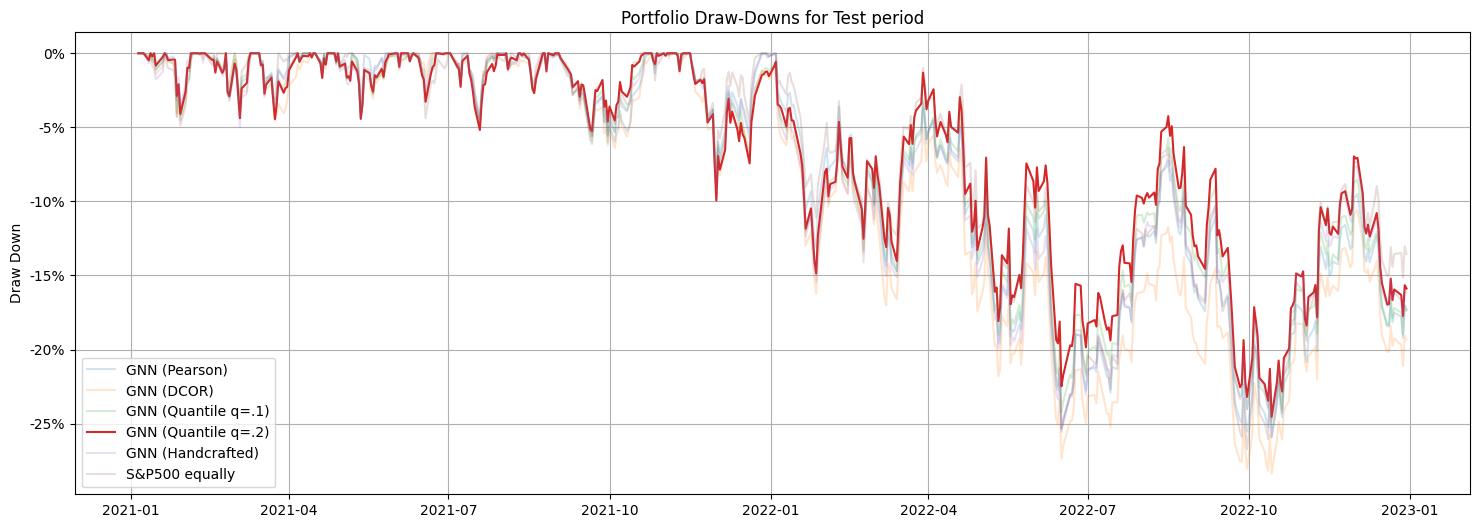

In [47]:
gnn_mis_pearson_mdd_test = drawdown_pct(gnn_mis_pearson_returns_cum_test)
gnn_mis_dcor_mdd_test = drawdown_pct(gnn_mis_dcor_returns_cum_test)
gnn_mis_handcrafted_mdd_test = drawdown_pct(gnn_mis_handcrafted_returns_cum_test)
gnn_mis_quantile_01_mdd_test = drawdown_pct(gnn_mis_quantile_01_returns_cum_test)
gnn_mis_quantile_02_mdd_test = drawdown_pct(gnn_mis_quantile_02_returns_cum_test)
gspc_equal_mdd_test = drawdown_pct(gspc_equal_returns_cum_test)

# Plot
alpha_value = 0.2
alpha_value_q = 1.0
_, ax = plt.subplots(figsize=(18,6))

ax.plot(gnn_mis_pearson_mdd_test, label="GNN (Pearson)", alpha=alpha_value)
ax.plot(gnn_mis_dcor_mdd_test, label="GNN (DCOR)", alpha=alpha_value)
ax.plot(gnn_mis_quantile_01_mdd_test, label="GNN (Quantile q=.1)", alpha=alpha_value)
ax.plot(gnn_mis_quantile_02_mdd_test, label="GNN (Quantile q=.2)", alpha=alpha_value_q)
ax.plot(gnn_mis_handcrafted_mdd_test, label="GNN (Handcrafted)", alpha=alpha_value)
ax.plot(gspc_equal_mdd_test, label="S&P500 equally", alpha=alpha_value)

ax.set_title("Portfolio Draw-Downs for Test period")
ax.set_ylabel("Draw Down")
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 
ax.legend()
ax.grid()
plt.show()

In [48]:
# Sharpe Ratios
df_sharpe_test = pd.concat([
    annualized_sharpe_ratio(df_returns=gnn_mis_pearson_returns_test, risk_free_rate=RISK_FREE_RATE, name='GNN (Pearson)'),
    annualized_sharpe_ratio(df_returns=gnn_mis_dcor_returns_test, risk_free_rate=RISK_FREE_RATE, name='GNN (DCOR)'),
    annualized_sharpe_ratio(df_returns=gnn_mis_quantile_01_returns_test, risk_free_rate=RISK_FREE_RATE, name='GNN (Quantile q=.1)'),
    annualized_sharpe_ratio(df_returns=gnn_mis_quantile_02_returns_test, risk_free_rate=RISK_FREE_RATE, name='GNN (Quantile q=.2)'),
    annualized_sharpe_ratio(df_returns=gnn_mis_handcrafted_returns_test, risk_free_rate=RISK_FREE_RATE, name='GNN (Handcrafted)'),
    annualized_sharpe_ratio(df_returns=gspc_equal_returns_test, risk_free_rate=RISK_FREE_RATE, name='S&P500 equally')
], axis=1).T

df_sharpe_test['Avg'] = df_sharpe_test.mean(axis=1)
df_sharpe_test.columns.rename('', inplace=True)
multi_idx = np.array([['Sharpe']*len(df_sharpe_test.index), df_sharpe_test.index.values])
multi_idx = pd.MultiIndex.from_arrays(multi_idx, names=('Metric', 'Portfolio'))
df_sharpe_test.index = multi_idx
df_sharpe_test.round(2)

2021  2022   Avg
Metric Portfolio                            
Sharpe GNN (Pearson)        1.96 -0.50  0.73
       GNN (DCOR)           1.70 -0.53  0.58
       GNN (Quantile q=.1)  1.82 -0.48  0.67
       GNN (Quantile q=.2)  1.87 -0.40  0.73
       GNN (Handcrafted)    1.87 -0.47  0.70
       S&P500 equally       2.17 -0.35  0.91

In [49]:
# Sortino Ratios
df_sortino_test = pd.concat([
    annualized_sortino_ratio(df_returns=gnn_mis_pearson_returns_test, risk_free_rate=RISK_FREE_RATE, name='GNN (Pearson)'),
    annualized_sortino_ratio(df_returns=gnn_mis_dcor_returns_test, risk_free_rate=RISK_FREE_RATE, name='GNN (DCOR)'),
    annualized_sortino_ratio(df_returns=gnn_mis_quantile_01_returns_test, risk_free_rate=RISK_FREE_RATE, name='GNN (Quantile q=.1)'),
    annualized_sortino_ratio(df_returns=gnn_mis_quantile_02_returns_test, risk_free_rate=RISK_FREE_RATE, name='GNN (Quantile q=.2)'),
    annualized_sortino_ratio(df_returns=gnn_mis_handcrafted_returns_test, risk_free_rate=RISK_FREE_RATE, name='GNN (Handcrafted)'),
    annualized_sortino_ratio(df_returns=gspc_equal_returns_test, risk_free_rate=RISK_FREE_RATE, name='S&P500 equally'),
], axis=1).T

df_sortino_test['Avg'] = df_sortino_test.mean(axis=1)
df_sortino_test.columns.rename('', inplace=True)
multi_idx = np.array([['Sortino']*len(df_sortino_test.index), df_sortino_test.index.values])
multi_idx = pd.MultiIndex.from_arrays(multi_idx, names=('Metric', 'Portfolio'))
df_sortino_test.index = multi_idx
df_sortino_test.round(2)

2021  2022   Avg
Metric  Portfolio                            
Sortino GNN (Pearson)        2.87 -0.82  1.02
        GNN (DCOR)           2.53 -0.89  0.82
        GNN (Quantile q=.1)  2.69 -0.79  0.95
        GNN (Quantile q=.2)  2.76 -0.66  1.05
        GNN (Handcrafted)    2.76 -0.78  0.99
        S&P500 equally       3.15 -0.57  1.29

In [50]:
# Maximal Draw Down
df_mdd_test = pd.concat([
    annualized_max_drawdown(df_returns=gnn_mis_pearson_returns_test, name='GNN (Pearson)'),
    annualized_max_drawdown(df_returns=gnn_mis_dcor_returns_test, name='GNN (DCOR)'),
    annualized_max_drawdown(df_returns=gnn_mis_quantile_01_returns_test, name='GNN (Quantile q=.1)'),
    annualized_max_drawdown(df_returns=gnn_mis_quantile_02_returns_test, name='GNN (Quantile q=.2)'),
    annualized_max_drawdown(df_returns=gnn_mis_handcrafted_returns_test, name='GNN (Handcrafted)'),
    annualized_max_drawdown(df_returns=gspc_equal_returns_test, name='S&P500 equally')
], axis=1).T

df_mdd_test['Avg'] = df_mdd_test.mean(axis=1)
df_mdd_test.columns.rename('', inplace=True)
multi_idx = np.array([['MDD']*len(df_mdd_test.index), df_mdd_test.index.values])
multi_idx = pd.MultiIndex.from_arrays(multi_idx, names=('Metric', 'Portfolio'))
df_mdd_test.index = multi_idx
df_mdd_test.round(2)

2021  2022   Avg
Metric Portfolio                            
MDD    GNN (Pearson)       -0.09 -0.26 -0.17
       GNN (DCOR)          -0.10 -0.28 -0.19
       GNN (Quantile q=.1) -0.09 -0.25 -0.17
       GNN (Quantile q=.2) -0.10 -0.25 -0.17
       GNN (Handcrafted)   -0.09 -0.26 -0.17
       S&P500 equally      -0.08 -0.27 -0.17

In [51]:
# Calmar Ratios
df_calmar_test = pd.concat([
    annualized_calmar_ratio(df_returns=gnn_mis_pearson_returns_test, risk_free_rate=RISK_FREE_RATE, name='GNN (Pearson)'),
    annualized_calmar_ratio(df_returns=gnn_mis_dcor_returns_test, risk_free_rate=RISK_FREE_RATE, name='GNN (DCOR)'),
    annualized_calmar_ratio(df_returns=gnn_mis_quantile_01_returns_test, risk_free_rate=RISK_FREE_RATE, name='GNN (Quantile q=.1)'),
    annualized_calmar_ratio(df_returns=gnn_mis_quantile_02_returns_test, risk_free_rate=RISK_FREE_RATE, name='GNN (Quantile q=.2)'),
    annualized_calmar_ratio(df_returns=gnn_mis_handcrafted_returns_test, risk_free_rate=RISK_FREE_RATE, name='GNN (Handcrafted)'),
    annualized_calmar_ratio(df_returns=gspc_equal_returns_test, risk_free_rate=RISK_FREE_RATE, name='S&P500 equally'),
], axis=1).T

df_calmar_test['Avg'] = df_calmar_test.mean(axis=1)
df_calmar_test.columns.rename('', inplace=True)
multi_idx = np.array([['Calmar']*len(df_calmar_test.index), df_calmar_test.index.values])
multi_idx = pd.MultiIndex.from_arrays(multi_idx, names=('Metric', 'Portfolio'))
df_calmar_test.index = multi_idx
df_calmar_test.round(2)

2021  2022   Avg
Metric Portfolio                            
Calmar GNN (Pearson)        2.95 -0.46  1.25
       GNN (DCOR)           2.28 -0.46  0.91
       GNN (Quantile q=.1)  2.75 -0.46  1.14
       GNN (Quantile q=.2)  2.59 -0.40  1.09
       GNN (Handcrafted)    2.68 -0.44  1.12
       S&P500 equally       3.58 -0.30  1.64

In [52]:
pd.concat([
    pd.concat([
        df_sharpe_train.round(2),
        df_sortino_train.round(2),
        df_mdd_train.round(2),
        df_calmar_train.round(2)
        ], axis=0),
    pd.concat([
        df_sharpe_val.round(2),
        df_sortino_val.round(2),
        df_mdd_val.round(2),
        df_calmar_val.round(2)
        ], axis=0),
    pd.concat([
        df_sharpe_test.round(2),
        df_sortino_test.round(2),
        df_mdd_test.round(2),
        df_calmar_test.round(2)
        ], axis=0)
], axis=1).to_csv('./data/backtest_evaluation_results.csv')